In [4]:
# Import libraries
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

In [6]:
# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

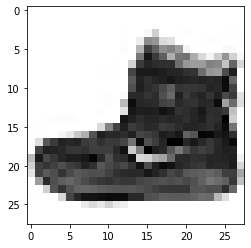

In [3]:
# Display one data point
plt.imshow(x_train[0], cmap='Greys')

In [9]:
# Rescale -1 to 1
x_train = x_train / 127.5 - 1.
x_train = np.expand_dims(x_train, axis=3)

In [10]:
# Define function for creating the generator
def create_generator():
  model = Sequential()

  model.add(Dense(256, input_dim=100))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(1024))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod((28, 28, 1)), activation='tanh'))
  model.add(Reshape((28, 28, 1)))

  model.summary()

  noise = Input(shape=(100,))
  img = model(noise)

  return Model(noise, img)

generator = create_generator()
z = Input(shape=(100,))
img = generator(z)

W1007 07:11:43.714423 140079874627328 deprecation_wrapper.py:119] From /misc/DLshare/home/rpcdz397/Projects/Marketing_Optimization/LTVModel/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1007 07:11:43.736189 140079874627328 deprecation_wrapper.py:119] From /misc/DLshare/home/rpcdz397/Projects/Marketing_Optimization/LTVModel/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1007 07:11:43.740469 140079874627328 deprecation_wrapper.py:119] From /misc/DLshare/home/rpcdz397/Projects/Marketing_Optimization/LTVModel/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1007 07:11:43.849222 140079874627328 deprecation_wrapper.py:119] From /misc/DLshare/home/rpcdz397/Projects/Ma

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
__________

In [11]:
# Create function for the discriminator
def create_discriminator():
  model = Sequential()

  model.add(Flatten(input_shape=(28, 28, 1)))
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=(28, 28, 1))
  validity = model(img)

  return Model(img, validity)

discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

W1007 07:12:11.912392 140079874627328 deprecation_wrapper.py:119] From /misc/DLshare/home/rpcdz397/Projects/Marketing_Optimization/LTVModel/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1007 07:12:11.918834 140079874627328 deprecation_wrapper.py:119] From /misc/DLshare/home/rpcdz397/Projects/Marketing_Optimization/LTVModel/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1007 07:12:11.924306 140079874627328 deprecation.py:323] From /misc/DLshare/home/rpcdz397/Projects/Marketing_Optimization/LTVModel/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Run model
validity = discriminator(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [13]:
# Create function for image sampling
def sample_images(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5*gen_imgs+0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1
  plt.show()
  plt.close()

/misc/DLshare/home/rpcdz397/Projects/Marketing_Optimization/LTVModel/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.912313, acc.: 29.69%] [G loss: 0.834867]


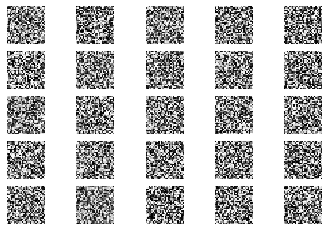

/misc/DLshare/home/rpcdz397/Projects/Marketing_Optimization/LTVModel/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.466311, acc.: 78.12%] [G loss: 0.869983]
2 [D loss: 0.333481, acc.: 89.06%] [G loss: 0.944518]
3 [D loss: 0.290699, acc.: 90.62%] [G loss: 1.056597]
4 [D loss: 0.224226, acc.: 100.00%] [G loss: 1.188033]
5 [D loss: 0.206144, acc.: 96.88%] [G loss: 1.243115]
6 [D loss: 0.239290, acc.: 95.31%] [G loss: 1.339591]
7 [D loss: 0.178772, acc.: 100.00%] [G loss: 1.538146]
8 [D loss: 0.115411, acc.: 100.00%] [G loss: 1.614161]
9 [D loss: 0.158507, acc.: 96.88%] [G loss: 1.745100]
10 [D loss: 0.150122, acc.: 100.00%] [G loss: 1.693326]
11 [D loss: 0.125228, acc.: 100.00%] [G loss: 1.861354]
12 [D loss: 0.103782, acc.: 100.00%] [G loss: 1.861626]
13 [D loss: 0.102536, acc.: 100.00%] [G loss: 1.945436]
14 [D loss: 0.107700, acc.: 100.00%] [G loss: 2.010344]
15 [D loss: 0.109456, acc.: 100.00%] [G loss: 2.111407]
16 [D loss: 0.096144, acc.: 100.00%] [G loss: 2.238347]
17 [D loss: 0.079507, acc.: 100.00%] [G loss: 2.233358]
18 [D loss: 0.076717, acc.: 100.00%] [G loss: 2.316208]
19 [D l

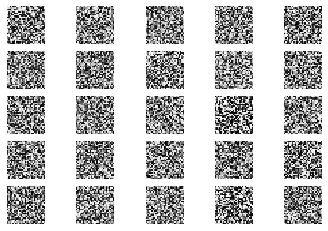

51 [D loss: 0.055743, acc.: 96.88%] [G loss: 3.448730]
52 [D loss: 0.029466, acc.: 100.00%] [G loss: 3.557936]
53 [D loss: 0.024341, acc.: 100.00%] [G loss: 3.669651]
54 [D loss: 0.023425, acc.: 100.00%] [G loss: 3.663716]
55 [D loss: 0.018316, acc.: 100.00%] [G loss: 3.631672]
56 [D loss: 0.019696, acc.: 100.00%] [G loss: 3.616755]
57 [D loss: 0.028584, acc.: 100.00%] [G loss: 3.758317]
58 [D loss: 0.025669, acc.: 100.00%] [G loss: 3.705085]
59 [D loss: 0.020187, acc.: 100.00%] [G loss: 3.854752]
60 [D loss: 0.018319, acc.: 100.00%] [G loss: 3.809150]
61 [D loss: 0.023328, acc.: 100.00%] [G loss: 3.858341]
62 [D loss: 0.016428, acc.: 100.00%] [G loss: 3.845952]
63 [D loss: 0.017210, acc.: 100.00%] [G loss: 3.973541]
64 [D loss: 0.020594, acc.: 100.00%] [G loss: 3.760117]
65 [D loss: 0.019470, acc.: 100.00%] [G loss: 4.013473]
66 [D loss: 0.021908, acc.: 100.00%] [G loss: 3.711414]
67 [D loss: 0.017735, acc.: 100.00%] [G loss: 4.047020]
68 [D loss: 0.015644, acc.: 100.00%] [G loss: 3.7

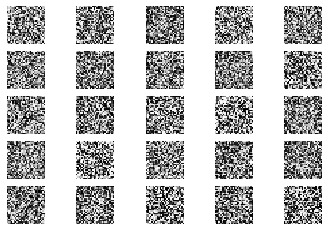

101 [D loss: 0.016856, acc.: 100.00%] [G loss: 4.412940]
102 [D loss: 0.015045, acc.: 100.00%] [G loss: 4.517527]
103 [D loss: 0.011665, acc.: 100.00%] [G loss: 4.444528]
104 [D loss: 0.012902, acc.: 100.00%] [G loss: 4.350141]
105 [D loss: 0.052335, acc.: 98.44%] [G loss: 4.445240]
106 [D loss: 0.016805, acc.: 100.00%] [G loss: 4.623239]
107 [D loss: 0.049876, acc.: 98.44%] [G loss: 4.410111]
108 [D loss: 0.017828, acc.: 100.00%] [G loss: 4.443844]
109 [D loss: 0.015820, acc.: 100.00%] [G loss: 4.570050]
110 [D loss: 0.012457, acc.: 100.00%] [G loss: 4.393053]
111 [D loss: 0.015702, acc.: 100.00%] [G loss: 4.538618]
112 [D loss: 0.038769, acc.: 98.44%] [G loss: 4.342403]
113 [D loss: 0.033264, acc.: 98.44%] [G loss: 4.340872]
114 [D loss: 0.018255, acc.: 100.00%] [G loss: 4.344682]
115 [D loss: 0.014745, acc.: 100.00%] [G loss: 4.368130]
116 [D loss: 0.013984, acc.: 100.00%] [G loss: 4.549417]
117 [D loss: 0.015938, acc.: 100.00%] [G loss: 4.597825]
118 [D loss: 0.023308, acc.: 100.00

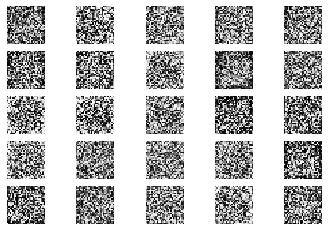

151 [D loss: 0.026531, acc.: 100.00%] [G loss: 4.711349]
152 [D loss: 0.037962, acc.: 100.00%] [G loss: 5.030414]
153 [D loss: 0.026106, acc.: 100.00%] [G loss: 4.713585]
154 [D loss: 0.048555, acc.: 100.00%] [G loss: 4.517684]
155 [D loss: 0.058092, acc.: 100.00%] [G loss: 4.383325]
156 [D loss: 0.029681, acc.: 98.44%] [G loss: 4.621663]
157 [D loss: 0.035570, acc.: 100.00%] [G loss: 4.449277]
158 [D loss: 0.021506, acc.: 100.00%] [G loss: 4.503558]
159 [D loss: 0.045019, acc.: 100.00%] [G loss: 5.028504]
160 [D loss: 0.118144, acc.: 98.44%] [G loss: 4.530747]
161 [D loss: 0.080511, acc.: 96.88%] [G loss: 4.307272]
162 [D loss: 0.033634, acc.: 98.44%] [G loss: 4.429029]
163 [D loss: 0.042408, acc.: 100.00%] [G loss: 4.644135]
164 [D loss: 0.037875, acc.: 100.00%] [G loss: 4.691904]
165 [D loss: 0.086762, acc.: 96.88%] [G loss: 4.773777]
166 [D loss: 0.103351, acc.: 96.88%] [G loss: 4.769308]
167 [D loss: 0.095050, acc.: 95.31%] [G loss: 4.604506]
168 [D loss: 0.097830, acc.: 95.31%] [

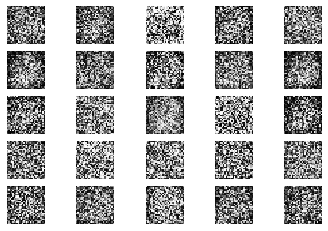

201 [D loss: 0.045759, acc.: 100.00%] [G loss: 5.417869]
202 [D loss: 0.213636, acc.: 95.31%] [G loss: 3.612569]
203 [D loss: 0.113618, acc.: 96.88%] [G loss: 4.206394]
204 [D loss: 0.038759, acc.: 100.00%] [G loss: 4.984126]
205 [D loss: 0.159705, acc.: 95.31%] [G loss: 4.387486]
206 [D loss: 0.173919, acc.: 90.62%] [G loss: 4.195392]
207 [D loss: 0.063649, acc.: 100.00%] [G loss: 4.862163]
208 [D loss: 0.065854, acc.: 96.88%] [G loss: 4.492584]
209 [D loss: 0.082727, acc.: 100.00%] [G loss: 4.354529]
210 [D loss: 0.040165, acc.: 98.44%] [G loss: 4.830710]
211 [D loss: 0.086379, acc.: 98.44%] [G loss: 4.814575]
212 [D loss: 0.051297, acc.: 98.44%] [G loss: 5.053279]
213 [D loss: 0.201716, acc.: 89.06%] [G loss: 4.505496]
214 [D loss: 0.108489, acc.: 95.31%] [G loss: 5.400318]
215 [D loss: 0.493268, acc.: 79.69%] [G loss: 3.485439]
216 [D loss: 0.144998, acc.: 92.19%] [G loss: 3.801742]
217 [D loss: 0.117999, acc.: 98.44%] [G loss: 4.139708]
218 [D loss: 0.133996, acc.: 93.75%] [G loss

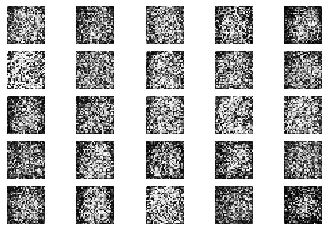

251 [D loss: 0.177447, acc.: 90.62%] [G loss: 3.883563]
252 [D loss: 0.115673, acc.: 96.88%] [G loss: 4.340146]
253 [D loss: 0.213058, acc.: 92.19%] [G loss: 4.176351]
254 [D loss: 0.100497, acc.: 100.00%] [G loss: 4.895763]
255 [D loss: 0.091483, acc.: 98.44%] [G loss: 4.129511]
256 [D loss: 0.285814, acc.: 89.06%] [G loss: 3.233913]
257 [D loss: 0.225587, acc.: 90.62%] [G loss: 4.369994]
258 [D loss: 0.324205, acc.: 79.69%] [G loss: 3.496030]
259 [D loss: 0.372589, acc.: 87.50%] [G loss: 4.106827]
260 [D loss: 0.113244, acc.: 98.44%] [G loss: 4.120045]
261 [D loss: 0.131298, acc.: 98.44%] [G loss: 3.687603]
262 [D loss: 0.107810, acc.: 96.88%] [G loss: 3.649920]
263 [D loss: 0.099409, acc.: 98.44%] [G loss: 4.437913]
264 [D loss: 0.176465, acc.: 92.19%] [G loss: 3.965462]
265 [D loss: 0.068664, acc.: 100.00%] [G loss: 3.296464]
266 [D loss: 0.203329, acc.: 90.62%] [G loss: 3.536162]
267 [D loss: 0.148378, acc.: 96.88%] [G loss: 4.188799]
268 [D loss: 0.153428, acc.: 90.62%] [G loss: 

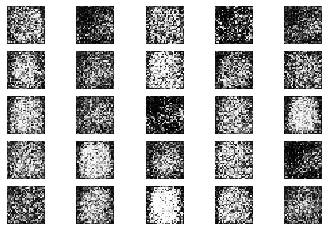

301 [D loss: 0.209119, acc.: 90.62%] [G loss: 4.836574]
302 [D loss: 0.184028, acc.: 95.31%] [G loss: 4.347843]
303 [D loss: 0.535743, acc.: 70.31%] [G loss: 3.775158]
304 [D loss: 0.102641, acc.: 96.88%] [G loss: 4.691597]
305 [D loss: 0.337365, acc.: 85.94%] [G loss: 2.772573]
306 [D loss: 0.238214, acc.: 89.06%] [G loss: 3.779833]
307 [D loss: 0.185199, acc.: 92.19%] [G loss: 3.985367]
308 [D loss: 0.215090, acc.: 92.19%] [G loss: 3.603383]
309 [D loss: 0.165311, acc.: 95.31%] [G loss: 4.762939]
310 [D loss: 0.625222, acc.: 70.31%] [G loss: 2.706835]
311 [D loss: 0.381530, acc.: 81.25%] [G loss: 3.123077]
312 [D loss: 0.083506, acc.: 98.44%] [G loss: 4.044645]
313 [D loss: 0.315607, acc.: 87.50%] [G loss: 3.425939]
314 [D loss: 0.440665, acc.: 79.69%] [G loss: 3.360690]
315 [D loss: 0.385329, acc.: 82.81%] [G loss: 3.030114]
316 [D loss: 0.319038, acc.: 90.62%] [G loss: 3.481216]
317 [D loss: 0.250347, acc.: 89.06%] [G loss: 3.755375]
318 [D loss: 0.650744, acc.: 79.69%] [G loss: 3.

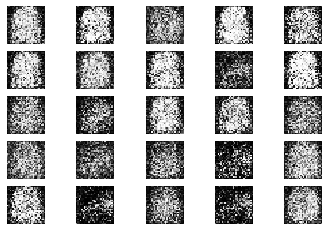

351 [D loss: 0.448350, acc.: 85.94%] [G loss: 2.535045]
352 [D loss: 0.407218, acc.: 85.94%] [G loss: 2.686040]
353 [D loss: 0.263016, acc.: 90.62%] [G loss: 2.674445]
354 [D loss: 0.420509, acc.: 76.56%] [G loss: 2.545424]
355 [D loss: 0.199809, acc.: 92.19%] [G loss: 3.199096]
356 [D loss: 0.272269, acc.: 95.31%] [G loss: 2.585856]
357 [D loss: 0.328228, acc.: 87.50%] [G loss: 2.925859]
358 [D loss: 0.361170, acc.: 84.38%] [G loss: 3.300156]
359 [D loss: 0.437002, acc.: 78.12%] [G loss: 2.761096]
360 [D loss: 0.436625, acc.: 79.69%] [G loss: 2.314767]
361 [D loss: 0.314042, acc.: 87.50%] [G loss: 2.640043]
362 [D loss: 0.506060, acc.: 70.31%] [G loss: 2.499506]
363 [D loss: 0.418603, acc.: 82.81%] [G loss: 2.564698]
364 [D loss: 0.564167, acc.: 79.69%] [G loss: 2.235491]
365 [D loss: 0.299045, acc.: 89.06%] [G loss: 3.171125]
366 [D loss: 0.555837, acc.: 75.00%] [G loss: 1.900574]
367 [D loss: 0.586516, acc.: 60.94%] [G loss: 2.468253]
368 [D loss: 0.324563, acc.: 84.38%] [G loss: 2.

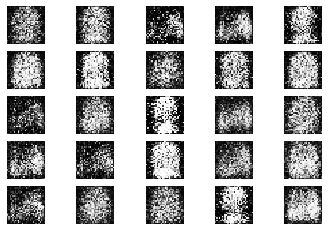

401 [D loss: 0.546234, acc.: 81.25%] [G loss: 2.248002]
402 [D loss: 0.608643, acc.: 71.88%] [G loss: 1.541725]
403 [D loss: 0.479248, acc.: 76.56%] [G loss: 2.039418]
404 [D loss: 0.770984, acc.: 67.19%] [G loss: 1.803872]
405 [D loss: 0.481944, acc.: 79.69%] [G loss: 1.790398]
406 [D loss: 0.735564, acc.: 53.12%] [G loss: 1.645082]
407 [D loss: 0.532357, acc.: 73.44%] [G loss: 2.158770]
408 [D loss: 0.776831, acc.: 65.62%] [G loss: 2.128317]
409 [D loss: 0.753216, acc.: 67.19%] [G loss: 1.944614]
410 [D loss: 0.509304, acc.: 76.56%] [G loss: 1.909477]
411 [D loss: 0.437721, acc.: 76.56%] [G loss: 2.720949]
412 [D loss: 0.691125, acc.: 67.19%] [G loss: 1.837476]
413 [D loss: 0.535834, acc.: 68.75%] [G loss: 2.106496]
414 [D loss: 0.577512, acc.: 65.62%] [G loss: 1.688266]
415 [D loss: 0.597968, acc.: 68.75%] [G loss: 2.011165]
416 [D loss: 0.382101, acc.: 85.94%] [G loss: 2.262576]
417 [D loss: 0.951513, acc.: 65.62%] [G loss: 1.245564]
418 [D loss: 0.765868, acc.: 64.06%] [G loss: 1.

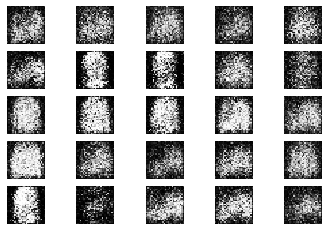

451 [D loss: 0.654047, acc.: 68.75%] [G loss: 1.378942]
452 [D loss: 0.507700, acc.: 76.56%] [G loss: 1.509781]
453 [D loss: 0.639399, acc.: 70.31%] [G loss: 1.468355]
454 [D loss: 0.737557, acc.: 62.50%] [G loss: 1.363138]
455 [D loss: 0.457261, acc.: 82.81%] [G loss: 1.437314]
456 [D loss: 0.679909, acc.: 70.31%] [G loss: 1.325594]
457 [D loss: 0.496159, acc.: 79.69%] [G loss: 1.288227]
458 [D loss: 0.558139, acc.: 75.00%] [G loss: 1.282886]
459 [D loss: 0.435636, acc.: 78.12%] [G loss: 1.519621]
460 [D loss: 0.528222, acc.: 79.69%] [G loss: 1.438096]
461 [D loss: 0.832509, acc.: 56.25%] [G loss: 1.216115]
462 [D loss: 0.698793, acc.: 64.06%] [G loss: 1.313819]
463 [D loss: 0.615739, acc.: 71.88%] [G loss: 1.417974]
464 [D loss: 0.526741, acc.: 78.12%] [G loss: 1.385619]
465 [D loss: 0.560860, acc.: 71.88%] [G loss: 1.334794]
466 [D loss: 0.594495, acc.: 78.12%] [G loss: 1.380824]
467 [D loss: 0.689741, acc.: 65.62%] [G loss: 1.302658]
468 [D loss: 0.718895, acc.: 64.06%] [G loss: 1.

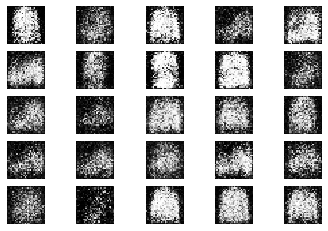

501 [D loss: 0.673265, acc.: 59.38%] [G loss: 1.132293]
502 [D loss: 0.711558, acc.: 53.12%] [G loss: 1.151391]
503 [D loss: 0.659863, acc.: 54.69%] [G loss: 1.138653]
504 [D loss: 0.529490, acc.: 79.69%] [G loss: 1.075006]
505 [D loss: 0.631466, acc.: 62.50%] [G loss: 1.118417]
506 [D loss: 0.647126, acc.: 65.62%] [G loss: 1.203946]
507 [D loss: 0.595311, acc.: 65.62%] [G loss: 1.208145]
508 [D loss: 0.489054, acc.: 82.81%] [G loss: 1.227602]
509 [D loss: 0.674059, acc.: 59.38%] [G loss: 1.112560]
510 [D loss: 0.590913, acc.: 73.44%] [G loss: 1.044400]
511 [D loss: 0.673996, acc.: 62.50%] [G loss: 1.144269]
512 [D loss: 0.641730, acc.: 67.19%] [G loss: 0.999247]
513 [D loss: 0.495539, acc.: 79.69%] [G loss: 1.204638]
514 [D loss: 0.554201, acc.: 75.00%] [G loss: 1.174333]
515 [D loss: 0.393357, acc.: 89.06%] [G loss: 1.336632]
516 [D loss: 0.561463, acc.: 76.56%] [G loss: 1.216289]
517 [D loss: 0.440998, acc.: 76.56%] [G loss: 1.220356]
518 [D loss: 0.650607, acc.: 67.19%] [G loss: 1.

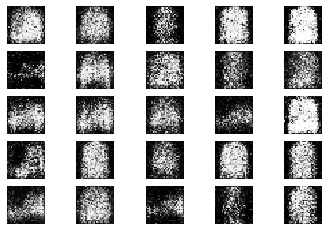

551 [D loss: 0.576139, acc.: 73.44%] [G loss: 1.219861]
552 [D loss: 0.718429, acc.: 54.69%] [G loss: 1.075508]
553 [D loss: 0.559490, acc.: 73.44%] [G loss: 1.149692]
554 [D loss: 0.687493, acc.: 57.81%] [G loss: 1.183948]
555 [D loss: 0.612860, acc.: 65.62%] [G loss: 1.164630]
556 [D loss: 0.717792, acc.: 60.94%] [G loss: 1.177249]
557 [D loss: 0.616539, acc.: 70.31%] [G loss: 1.142242]
558 [D loss: 0.627947, acc.: 62.50%] [G loss: 1.101307]
559 [D loss: 0.496556, acc.: 75.00%] [G loss: 1.170037]
560 [D loss: 0.492432, acc.: 81.25%] [G loss: 1.291637]
561 [D loss: 0.529121, acc.: 76.56%] [G loss: 1.151517]
562 [D loss: 0.484505, acc.: 78.12%] [G loss: 1.140390]
563 [D loss: 0.666081, acc.: 65.62%] [G loss: 1.167123]
564 [D loss: 0.540397, acc.: 82.81%] [G loss: 1.174128]
565 [D loss: 0.513485, acc.: 81.25%] [G loss: 1.162088]
566 [D loss: 0.550465, acc.: 67.19%] [G loss: 1.125096]
567 [D loss: 0.565094, acc.: 71.88%] [G loss: 1.035311]
568 [D loss: 0.505599, acc.: 79.69%] [G loss: 1.

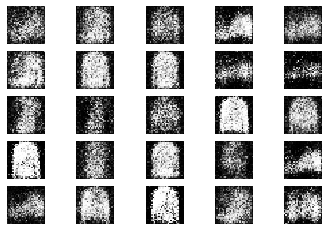

601 [D loss: 0.550222, acc.: 73.44%] [G loss: 1.139946]
602 [D loss: 0.665046, acc.: 57.81%] [G loss: 1.181690]
603 [D loss: 0.677417, acc.: 59.38%] [G loss: 1.220298]
604 [D loss: 0.608527, acc.: 71.88%] [G loss: 1.125132]
605 [D loss: 0.539546, acc.: 76.56%] [G loss: 0.993853]
606 [D loss: 0.576407, acc.: 75.00%] [G loss: 1.039934]
607 [D loss: 0.506488, acc.: 82.81%] [G loss: 1.098612]
608 [D loss: 0.580287, acc.: 70.31%] [G loss: 1.147416]
609 [D loss: 0.535986, acc.: 73.44%] [G loss: 1.085482]
610 [D loss: 0.522588, acc.: 73.44%] [G loss: 1.199679]
611 [D loss: 0.547050, acc.: 75.00%] [G loss: 1.035033]
612 [D loss: 0.642091, acc.: 62.50%] [G loss: 1.095382]
613 [D loss: 0.584087, acc.: 71.88%] [G loss: 1.091327]
614 [D loss: 0.531251, acc.: 73.44%] [G loss: 1.174813]
615 [D loss: 0.600905, acc.: 64.06%] [G loss: 1.157226]
616 [D loss: 0.592934, acc.: 65.62%] [G loss: 1.134662]
617 [D loss: 0.510625, acc.: 79.69%] [G loss: 1.074081]
618 [D loss: 0.620352, acc.: 64.06%] [G loss: 1.

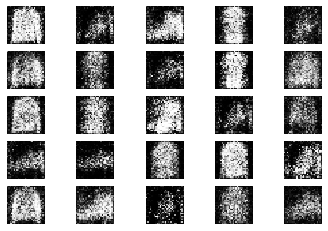

651 [D loss: 0.473498, acc.: 81.25%] [G loss: 1.189474]
652 [D loss: 0.640596, acc.: 60.94%] [G loss: 1.131255]
653 [D loss: 0.520144, acc.: 73.44%] [G loss: 1.087504]
654 [D loss: 0.527577, acc.: 78.12%] [G loss: 1.054319]
655 [D loss: 0.588891, acc.: 67.19%] [G loss: 1.009359]
656 [D loss: 0.516643, acc.: 82.81%] [G loss: 1.139002]
657 [D loss: 0.489331, acc.: 79.69%] [G loss: 1.038106]
658 [D loss: 0.535917, acc.: 75.00%] [G loss: 1.087196]
659 [D loss: 0.546789, acc.: 79.69%] [G loss: 1.091779]
660 [D loss: 0.547065, acc.: 73.44%] [G loss: 1.052074]
661 [D loss: 0.501561, acc.: 79.69%] [G loss: 1.012497]
662 [D loss: 0.549511, acc.: 71.88%] [G loss: 1.062440]
663 [D loss: 0.476721, acc.: 78.12%] [G loss: 0.950426]
664 [D loss: 0.594304, acc.: 68.75%] [G loss: 1.093037]
665 [D loss: 0.500978, acc.: 71.88%] [G loss: 1.283386]
666 [D loss: 0.595260, acc.: 68.75%] [G loss: 1.173167]
667 [D loss: 0.434405, acc.: 81.25%] [G loss: 1.161414]
668 [D loss: 0.582796, acc.: 65.62%] [G loss: 1.

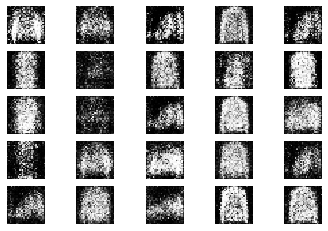

701 [D loss: 0.564941, acc.: 76.56%] [G loss: 1.196934]
702 [D loss: 0.536033, acc.: 78.12%] [G loss: 1.226789]
703 [D loss: 0.513601, acc.: 79.69%] [G loss: 1.088486]
704 [D loss: 0.620885, acc.: 59.38%] [G loss: 1.076298]
705 [D loss: 0.504838, acc.: 79.69%] [G loss: 1.147719]
706 [D loss: 0.528277, acc.: 79.69%] [G loss: 1.218381]
707 [D loss: 0.549562, acc.: 73.44%] [G loss: 1.126714]
708 [D loss: 0.593042, acc.: 75.00%] [G loss: 0.972978]
709 [D loss: 0.556119, acc.: 67.19%] [G loss: 1.006511]
710 [D loss: 0.620255, acc.: 65.62%] [G loss: 1.084712]
711 [D loss: 0.557378, acc.: 73.44%] [G loss: 1.117587]
712 [D loss: 0.479668, acc.: 78.12%] [G loss: 1.075323]
713 [D loss: 0.523012, acc.: 78.12%] [G loss: 1.147353]
714 [D loss: 0.589157, acc.: 67.19%] [G loss: 1.152566]
715 [D loss: 0.643007, acc.: 65.62%] [G loss: 1.085504]
716 [D loss: 0.511953, acc.: 78.12%] [G loss: 1.087742]
717 [D loss: 0.486189, acc.: 81.25%] [G loss: 1.228337]
718 [D loss: 0.576209, acc.: 75.00%] [G loss: 1.

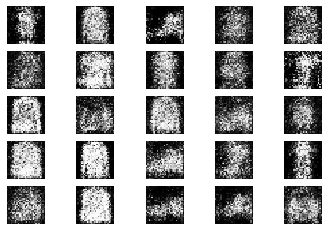

751 [D loss: 0.485316, acc.: 81.25%] [G loss: 1.276512]
752 [D loss: 0.553751, acc.: 71.88%] [G loss: 1.164745]
753 [D loss: 0.515485, acc.: 71.88%] [G loss: 1.144696]
754 [D loss: 0.479977, acc.: 81.25%] [G loss: 1.241925]
755 [D loss: 0.633489, acc.: 59.38%] [G loss: 1.120113]
756 [D loss: 0.447292, acc.: 84.38%] [G loss: 1.226661]
757 [D loss: 0.565900, acc.: 71.88%] [G loss: 1.222291]
758 [D loss: 0.539634, acc.: 73.44%] [G loss: 1.046076]
759 [D loss: 0.541137, acc.: 78.12%] [G loss: 1.046355]
760 [D loss: 0.630912, acc.: 65.62%] [G loss: 1.040929]
761 [D loss: 0.608145, acc.: 64.06%] [G loss: 1.120318]
762 [D loss: 0.600765, acc.: 67.19%] [G loss: 1.164587]
763 [D loss: 0.567140, acc.: 73.44%] [G loss: 1.135696]
764 [D loss: 0.555714, acc.: 73.44%] [G loss: 1.147135]
765 [D loss: 0.587955, acc.: 65.62%] [G loss: 1.201827]
766 [D loss: 0.593179, acc.: 64.06%] [G loss: 1.214975]
767 [D loss: 0.617032, acc.: 73.44%] [G loss: 1.101694]
768 [D loss: 0.540208, acc.: 75.00%] [G loss: 1.

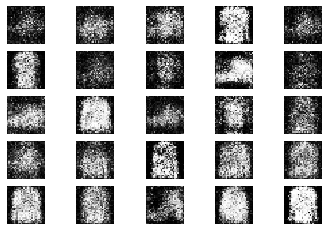

801 [D loss: 0.560256, acc.: 71.88%] [G loss: 1.065337]
802 [D loss: 0.547347, acc.: 75.00%] [G loss: 1.040222]
803 [D loss: 0.533581, acc.: 76.56%] [G loss: 1.139418]
804 [D loss: 0.580655, acc.: 70.31%] [G loss: 1.110260]
805 [D loss: 0.544908, acc.: 70.31%] [G loss: 1.182494]
806 [D loss: 0.594495, acc.: 67.19%] [G loss: 1.226746]
807 [D loss: 0.597797, acc.: 70.31%] [G loss: 1.181484]
808 [D loss: 0.480296, acc.: 78.12%] [G loss: 1.202884]
809 [D loss: 0.504888, acc.: 82.81%] [G loss: 1.118826]
810 [D loss: 0.621748, acc.: 65.62%] [G loss: 1.091174]
811 [D loss: 0.613832, acc.: 64.06%] [G loss: 1.116696]
812 [D loss: 0.526460, acc.: 70.31%] [G loss: 1.278232]
813 [D loss: 0.583745, acc.: 67.19%] [G loss: 1.142449]
814 [D loss: 0.510752, acc.: 76.56%] [G loss: 1.156269]
815 [D loss: 0.458292, acc.: 76.56%] [G loss: 1.016245]
816 [D loss: 0.615810, acc.: 65.62%] [G loss: 0.977373]
817 [D loss: 0.471481, acc.: 78.12%] [G loss: 1.275930]
818 [D loss: 0.536663, acc.: 76.56%] [G loss: 1.

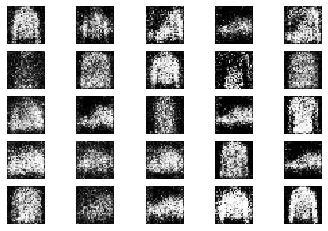

851 [D loss: 0.565217, acc.: 68.75%] [G loss: 1.243539]
852 [D loss: 0.624705, acc.: 57.81%] [G loss: 1.101967]
853 [D loss: 0.576492, acc.: 67.19%] [G loss: 1.287245]
854 [D loss: 0.612772, acc.: 67.19%] [G loss: 1.134071]
855 [D loss: 0.583450, acc.: 65.62%] [G loss: 1.221293]
856 [D loss: 0.732690, acc.: 62.50%] [G loss: 0.926754]
857 [D loss: 0.529177, acc.: 76.56%] [G loss: 1.061044]
858 [D loss: 0.541748, acc.: 71.88%] [G loss: 1.057679]
859 [D loss: 0.594236, acc.: 67.19%] [G loss: 1.111610]
860 [D loss: 0.486821, acc.: 76.56%] [G loss: 1.130946]
861 [D loss: 0.554274, acc.: 71.88%] [G loss: 1.113452]
862 [D loss: 0.604561, acc.: 62.50%] [G loss: 1.104662]
863 [D loss: 0.524174, acc.: 75.00%] [G loss: 1.089070]
864 [D loss: 0.599714, acc.: 73.44%] [G loss: 1.228456]
865 [D loss: 0.588326, acc.: 65.62%] [G loss: 1.212456]
866 [D loss: 0.683917, acc.: 62.50%] [G loss: 1.171459]
867 [D loss: 0.586738, acc.: 65.62%] [G loss: 1.061194]
868 [D loss: 0.649297, acc.: 62.50%] [G loss: 0.

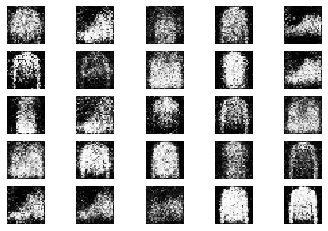

901 [D loss: 0.648025, acc.: 53.12%] [G loss: 0.980457]
902 [D loss: 0.590343, acc.: 67.19%] [G loss: 1.016843]
903 [D loss: 0.570574, acc.: 71.88%] [G loss: 1.020551]
904 [D loss: 0.656945, acc.: 59.38%] [G loss: 1.028019]
905 [D loss: 0.681151, acc.: 62.50%] [G loss: 1.005355]
906 [D loss: 0.649730, acc.: 57.81%] [G loss: 0.990153]
907 [D loss: 0.618643, acc.: 65.62%] [G loss: 1.063338]
908 [D loss: 0.634566, acc.: 65.62%] [G loss: 0.932022]
909 [D loss: 0.627860, acc.: 67.19%] [G loss: 1.135616]
910 [D loss: 0.693812, acc.: 54.69%] [G loss: 1.065367]
911 [D loss: 0.553247, acc.: 75.00%] [G loss: 1.028099]
912 [D loss: 0.614076, acc.: 67.19%] [G loss: 0.954176]
913 [D loss: 0.628905, acc.: 65.62%] [G loss: 1.025024]
914 [D loss: 0.704111, acc.: 59.38%] [G loss: 1.101223]
915 [D loss: 0.616892, acc.: 68.75%] [G loss: 1.066710]
916 [D loss: 0.721291, acc.: 50.00%] [G loss: 0.975115]
917 [D loss: 0.634928, acc.: 62.50%] [G loss: 0.885554]
918 [D loss: 0.563892, acc.: 75.00%] [G loss: 1.

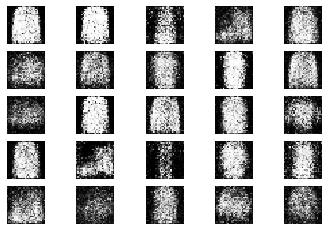

951 [D loss: 0.488668, acc.: 79.69%] [G loss: 1.033936]
952 [D loss: 0.518999, acc.: 73.44%] [G loss: 0.994625]
953 [D loss: 0.587669, acc.: 64.06%] [G loss: 0.921994]
954 [D loss: 0.627230, acc.: 59.38%] [G loss: 1.003476]
955 [D loss: 0.568886, acc.: 68.75%] [G loss: 1.099373]
956 [D loss: 0.618234, acc.: 71.88%] [G loss: 1.157728]
957 [D loss: 0.662967, acc.: 62.50%] [G loss: 1.004784]
958 [D loss: 0.595108, acc.: 67.19%] [G loss: 0.969926]
959 [D loss: 0.578141, acc.: 68.75%] [G loss: 0.997295]
960 [D loss: 0.673272, acc.: 62.50%] [G loss: 1.051336]
961 [D loss: 0.555596, acc.: 75.00%] [G loss: 0.972221]
962 [D loss: 0.557653, acc.: 75.00%] [G loss: 1.032519]
963 [D loss: 0.584341, acc.: 75.00%] [G loss: 1.225557]
964 [D loss: 0.560434, acc.: 71.88%] [G loss: 1.300685]
965 [D loss: 0.577192, acc.: 75.00%] [G loss: 1.148846]
966 [D loss: 0.602349, acc.: 62.50%] [G loss: 1.070733]
967 [D loss: 0.582699, acc.: 70.31%] [G loss: 1.058632]
968 [D loss: 0.614084, acc.: 65.62%] [G loss: 1.

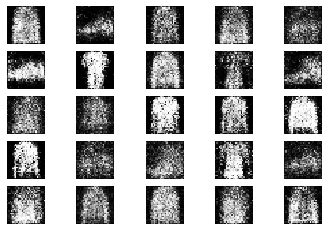

1001 [D loss: 0.611031, acc.: 64.06%] [G loss: 1.003147]
1002 [D loss: 0.633659, acc.: 62.50%] [G loss: 1.097244]
1003 [D loss: 0.680208, acc.: 54.69%] [G loss: 1.030943]
1004 [D loss: 0.551509, acc.: 78.12%] [G loss: 1.127840]
1005 [D loss: 0.645184, acc.: 62.50%] [G loss: 1.040915]
1006 [D loss: 0.571248, acc.: 71.88%] [G loss: 1.097315]
1007 [D loss: 0.652046, acc.: 59.38%] [G loss: 1.059426]
1008 [D loss: 0.565647, acc.: 70.31%] [G loss: 1.119165]
1009 [D loss: 0.614755, acc.: 62.50%] [G loss: 0.923538]
1010 [D loss: 0.696406, acc.: 59.38%] [G loss: 0.966957]
1011 [D loss: 0.535686, acc.: 76.56%] [G loss: 0.974312]
1012 [D loss: 0.555443, acc.: 71.88%] [G loss: 1.038963]
1013 [D loss: 0.586033, acc.: 68.75%] [G loss: 0.965718]
1014 [D loss: 0.627116, acc.: 59.38%] [G loss: 1.035536]
1015 [D loss: 0.526194, acc.: 73.44%] [G loss: 1.004111]
1016 [D loss: 0.673571, acc.: 60.94%] [G loss: 1.077340]
1017 [D loss: 0.613625, acc.: 65.62%] [G loss: 0.903245]
1018 [D loss: 0.629175, acc.: 6

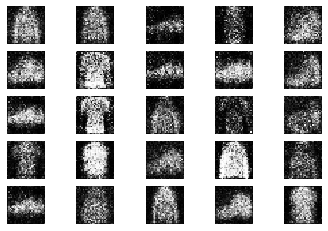

1051 [D loss: 0.562174, acc.: 75.00%] [G loss: 1.035116]
1052 [D loss: 0.559795, acc.: 73.44%] [G loss: 1.093457]
1053 [D loss: 0.621368, acc.: 65.62%] [G loss: 1.012494]
1054 [D loss: 0.571681, acc.: 65.62%] [G loss: 1.077507]
1055 [D loss: 0.691837, acc.: 60.94%] [G loss: 0.811894]
1056 [D loss: 0.602800, acc.: 64.06%] [G loss: 0.972849]
1057 [D loss: 0.571613, acc.: 71.88%] [G loss: 0.963392]
1058 [D loss: 0.570473, acc.: 64.06%] [G loss: 0.989651]
1059 [D loss: 0.688921, acc.: 62.50%] [G loss: 0.971600]
1060 [D loss: 0.573023, acc.: 62.50%] [G loss: 0.980293]
1061 [D loss: 0.603471, acc.: 65.62%] [G loss: 1.002127]
1062 [D loss: 0.568618, acc.: 73.44%] [G loss: 1.075726]
1063 [D loss: 0.581446, acc.: 76.56%] [G loss: 1.130754]
1064 [D loss: 0.596388, acc.: 64.06%] [G loss: 0.969305]
1065 [D loss: 0.568673, acc.: 68.75%] [G loss: 0.944469]
1066 [D loss: 0.570520, acc.: 70.31%] [G loss: 0.861963]
1067 [D loss: 0.612630, acc.: 67.19%] [G loss: 0.855510]
1068 [D loss: 0.593353, acc.: 6

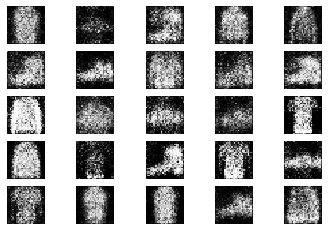

1101 [D loss: 0.593193, acc.: 68.75%] [G loss: 1.056942]
1102 [D loss: 0.564169, acc.: 79.69%] [G loss: 1.031877]
1103 [D loss: 0.615787, acc.: 62.50%] [G loss: 0.957329]
1104 [D loss: 0.702489, acc.: 64.06%] [G loss: 0.869194]
1105 [D loss: 0.555507, acc.: 73.44%] [G loss: 0.973337]
1106 [D loss: 0.657260, acc.: 56.25%] [G loss: 1.014349]
1107 [D loss: 0.613144, acc.: 67.19%] [G loss: 1.077280]
1108 [D loss: 0.590710, acc.: 67.19%] [G loss: 0.986212]
1109 [D loss: 0.617847, acc.: 64.06%] [G loss: 1.049012]
1110 [D loss: 0.644556, acc.: 64.06%] [G loss: 0.983165]
1111 [D loss: 0.602818, acc.: 73.44%] [G loss: 1.153694]
1112 [D loss: 0.669817, acc.: 50.00%] [G loss: 0.970621]
1113 [D loss: 0.568966, acc.: 71.88%] [G loss: 0.943733]
1114 [D loss: 0.542196, acc.: 73.44%] [G loss: 0.979158]
1115 [D loss: 0.617004, acc.: 64.06%] [G loss: 1.027287]
1116 [D loss: 0.692075, acc.: 60.94%] [G loss: 1.004797]
1117 [D loss: 0.651831, acc.: 65.62%] [G loss: 1.001136]
1118 [D loss: 0.628478, acc.: 6

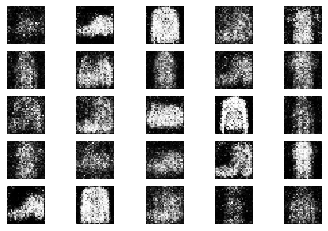

1151 [D loss: 0.634739, acc.: 57.81%] [G loss: 0.981717]
1152 [D loss: 0.586818, acc.: 70.31%] [G loss: 0.891637]
1153 [D loss: 0.615307, acc.: 67.19%] [G loss: 0.914992]
1154 [D loss: 0.669502, acc.: 57.81%] [G loss: 0.929950]
1155 [D loss: 0.563144, acc.: 79.69%] [G loss: 0.864979]
1156 [D loss: 0.635560, acc.: 64.06%] [G loss: 0.817097]
1157 [D loss: 0.553025, acc.: 64.06%] [G loss: 0.900110]
1158 [D loss: 0.616216, acc.: 64.06%] [G loss: 1.022749]
1159 [D loss: 0.560906, acc.: 67.19%] [G loss: 0.991708]
1160 [D loss: 0.659586, acc.: 62.50%] [G loss: 0.860896]
1161 [D loss: 0.635069, acc.: 68.75%] [G loss: 0.933521]
1162 [D loss: 0.587016, acc.: 67.19%] [G loss: 0.983796]
1163 [D loss: 0.635585, acc.: 62.50%] [G loss: 0.982412]
1164 [D loss: 0.567587, acc.: 78.12%] [G loss: 0.965907]
1165 [D loss: 0.645067, acc.: 57.81%] [G loss: 0.965198]
1166 [D loss: 0.612445, acc.: 59.38%] [G loss: 0.941996]
1167 [D loss: 0.550611, acc.: 75.00%] [G loss: 0.938832]
1168 [D loss: 0.599428, acc.: 7

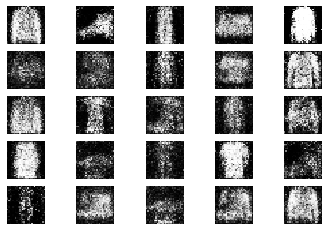

1201 [D loss: 0.587968, acc.: 65.62%] [G loss: 0.914623]
1202 [D loss: 0.607810, acc.: 65.62%] [G loss: 1.049531]
1203 [D loss: 0.653670, acc.: 65.62%] [G loss: 0.979729]
1204 [D loss: 0.601612, acc.: 67.19%] [G loss: 0.912955]
1205 [D loss: 0.691285, acc.: 57.81%] [G loss: 0.910997]
1206 [D loss: 0.574057, acc.: 68.75%] [G loss: 1.056091]
1207 [D loss: 0.539699, acc.: 67.19%] [G loss: 0.976789]
1208 [D loss: 0.626412, acc.: 68.75%] [G loss: 0.964372]
1209 [D loss: 0.641260, acc.: 57.81%] [G loss: 0.868381]
1210 [D loss: 0.544629, acc.: 68.75%] [G loss: 0.968384]
1211 [D loss: 0.639374, acc.: 64.06%] [G loss: 0.990058]
1212 [D loss: 0.619601, acc.: 60.94%] [G loss: 1.048381]
1213 [D loss: 0.647636, acc.: 57.81%] [G loss: 0.979117]
1214 [D loss: 0.632719, acc.: 59.38%] [G loss: 0.982931]
1215 [D loss: 0.669040, acc.: 59.38%] [G loss: 1.045236]
1216 [D loss: 0.599783, acc.: 67.19%] [G loss: 1.042428]
1217 [D loss: 0.696224, acc.: 54.69%] [G loss: 0.984857]
1218 [D loss: 0.625318, acc.: 6

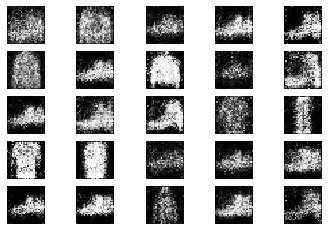

1251 [D loss: 0.592753, acc.: 67.19%] [G loss: 0.957040]
1252 [D loss: 0.665802, acc.: 62.50%] [G loss: 0.921321]
1253 [D loss: 0.591028, acc.: 62.50%] [G loss: 0.901387]
1254 [D loss: 0.551832, acc.: 65.62%] [G loss: 0.980799]
1255 [D loss: 0.580457, acc.: 70.31%] [G loss: 1.062533]
1256 [D loss: 0.633435, acc.: 60.94%] [G loss: 0.988495]
1257 [D loss: 0.658212, acc.: 59.38%] [G loss: 1.011685]
1258 [D loss: 0.633808, acc.: 64.06%] [G loss: 0.901137]
1259 [D loss: 0.595846, acc.: 73.44%] [G loss: 0.994454]
1260 [D loss: 0.626078, acc.: 67.19%] [G loss: 1.019884]
1261 [D loss: 0.614794, acc.: 67.19%] [G loss: 1.019030]
1262 [D loss: 0.600592, acc.: 68.75%] [G loss: 0.980319]
1263 [D loss: 0.620042, acc.: 65.62%] [G loss: 0.921254]
1264 [D loss: 0.583022, acc.: 73.44%] [G loss: 0.866666]
1265 [D loss: 0.713866, acc.: 64.06%] [G loss: 0.920930]
1266 [D loss: 0.607683, acc.: 68.75%] [G loss: 0.913656]
1267 [D loss: 0.601776, acc.: 67.19%] [G loss: 0.828296]
1268 [D loss: 0.640856, acc.: 5

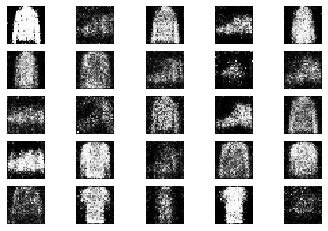

1301 [D loss: 0.557542, acc.: 75.00%] [G loss: 0.905694]
1302 [D loss: 0.668775, acc.: 65.62%] [G loss: 0.892603]
1303 [D loss: 0.618863, acc.: 68.75%] [G loss: 0.961103]
1304 [D loss: 0.642894, acc.: 62.50%] [G loss: 0.897138]
1305 [D loss: 0.655321, acc.: 64.06%] [G loss: 0.890536]
1306 [D loss: 0.580773, acc.: 73.44%] [G loss: 0.860835]
1307 [D loss: 0.590062, acc.: 65.62%] [G loss: 0.926484]
1308 [D loss: 0.605279, acc.: 70.31%] [G loss: 0.876722]
1309 [D loss: 0.651924, acc.: 59.38%] [G loss: 0.778576]
1310 [D loss: 0.606887, acc.: 64.06%] [G loss: 0.866050]
1311 [D loss: 0.620766, acc.: 67.19%] [G loss: 0.887557]
1312 [D loss: 0.568007, acc.: 73.44%] [G loss: 0.828036]
1313 [D loss: 0.621346, acc.: 70.31%] [G loss: 0.975026]
1314 [D loss: 0.627538, acc.: 57.81%] [G loss: 0.999331]
1315 [D loss: 0.594173, acc.: 70.31%] [G loss: 0.927505]
1316 [D loss: 0.640049, acc.: 54.69%] [G loss: 0.910612]
1317 [D loss: 0.672309, acc.: 51.56%] [G loss: 0.857851]
1318 [D loss: 0.589592, acc.: 6

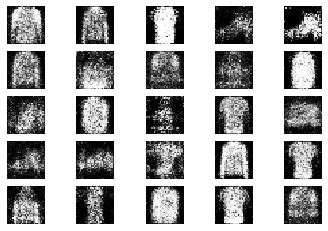

1351 [D loss: 0.650123, acc.: 62.50%] [G loss: 0.944607]
1352 [D loss: 0.626933, acc.: 67.19%] [G loss: 0.893835]
1353 [D loss: 0.507166, acc.: 81.25%] [G loss: 0.914866]
1354 [D loss: 0.635694, acc.: 65.62%] [G loss: 0.927994]
1355 [D loss: 0.607640, acc.: 65.62%] [G loss: 0.967756]
1356 [D loss: 0.598876, acc.: 68.75%] [G loss: 0.929462]
1357 [D loss: 0.589897, acc.: 73.44%] [G loss: 0.970920]
1358 [D loss: 0.565489, acc.: 71.88%] [G loss: 0.881541]
1359 [D loss: 0.598915, acc.: 59.38%] [G loss: 0.905591]
1360 [D loss: 0.617468, acc.: 70.31%] [G loss: 0.945956]
1361 [D loss: 0.670729, acc.: 60.94%] [G loss: 0.910449]
1362 [D loss: 0.571342, acc.: 75.00%] [G loss: 0.929625]
1363 [D loss: 0.611297, acc.: 67.19%] [G loss: 0.925240]
1364 [D loss: 0.560599, acc.: 75.00%] [G loss: 0.968168]
1365 [D loss: 0.565914, acc.: 71.88%] [G loss: 1.068651]
1366 [D loss: 0.624376, acc.: 59.38%] [G loss: 0.963305]
1367 [D loss: 0.529900, acc.: 75.00%] [G loss: 1.074928]
1368 [D loss: 0.665749, acc.: 6

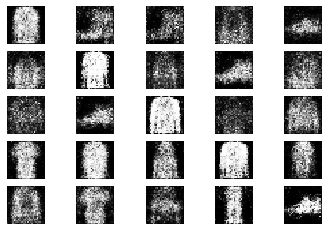

1401 [D loss: 0.683565, acc.: 50.00%] [G loss: 0.917885]
1402 [D loss: 0.586891, acc.: 70.31%] [G loss: 0.991829]
1403 [D loss: 0.696786, acc.: 56.25%] [G loss: 0.930307]
1404 [D loss: 0.619568, acc.: 62.50%] [G loss: 0.894693]
1405 [D loss: 0.608698, acc.: 64.06%] [G loss: 0.907294]
1406 [D loss: 0.606873, acc.: 70.31%] [G loss: 0.988621]
1407 [D loss: 0.666958, acc.: 59.38%] [G loss: 0.840531]
1408 [D loss: 0.601166, acc.: 64.06%] [G loss: 0.858320]
1409 [D loss: 0.567622, acc.: 73.44%] [G loss: 0.916809]
1410 [D loss: 0.663220, acc.: 57.81%] [G loss: 0.887447]
1411 [D loss: 0.590194, acc.: 71.88%] [G loss: 0.954343]
1412 [D loss: 0.665096, acc.: 60.94%] [G loss: 0.871955]
1413 [D loss: 0.685364, acc.: 56.25%] [G loss: 0.883890]
1414 [D loss: 0.664757, acc.: 59.38%] [G loss: 0.875137]
1415 [D loss: 0.625260, acc.: 64.06%] [G loss: 0.806708]
1416 [D loss: 0.548708, acc.: 75.00%] [G loss: 0.908485]
1417 [D loss: 0.590625, acc.: 68.75%] [G loss: 0.856507]
1418 [D loss: 0.559027, acc.: 7

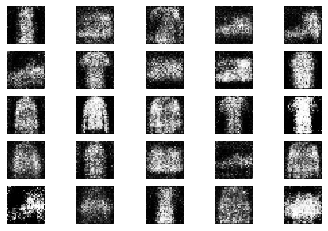

1451 [D loss: 0.619717, acc.: 68.75%] [G loss: 0.989170]
1452 [D loss: 0.660202, acc.: 65.62%] [G loss: 0.902943]
1453 [D loss: 0.555186, acc.: 76.56%] [G loss: 0.899305]
1454 [D loss: 0.638693, acc.: 65.62%] [G loss: 0.910395]
1455 [D loss: 0.632119, acc.: 65.62%] [G loss: 0.966993]
1456 [D loss: 0.670931, acc.: 51.56%] [G loss: 0.930333]
1457 [D loss: 0.646770, acc.: 68.75%] [G loss: 0.874422]
1458 [D loss: 0.547550, acc.: 75.00%] [G loss: 0.924632]
1459 [D loss: 0.587950, acc.: 70.31%] [G loss: 0.911632]
1460 [D loss: 0.629220, acc.: 62.50%] [G loss: 0.929687]
1461 [D loss: 0.616751, acc.: 60.94%] [G loss: 0.967797]
1462 [D loss: 0.613451, acc.: 68.75%] [G loss: 0.900695]
1463 [D loss: 0.596557, acc.: 73.44%] [G loss: 0.782657]
1464 [D loss: 0.642327, acc.: 65.62%] [G loss: 0.907704]
1465 [D loss: 0.591736, acc.: 68.75%] [G loss: 0.896572]
1466 [D loss: 0.642446, acc.: 64.06%] [G loss: 0.884061]
1467 [D loss: 0.570071, acc.: 71.88%] [G loss: 0.941665]
1468 [D loss: 0.595251, acc.: 7

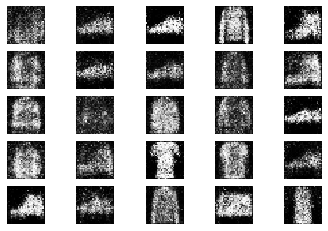

1501 [D loss: 0.578362, acc.: 73.44%] [G loss: 0.825644]
1502 [D loss: 0.609063, acc.: 68.75%] [G loss: 0.928756]
1503 [D loss: 0.654169, acc.: 60.94%] [G loss: 1.018002]
1504 [D loss: 0.595481, acc.: 65.62%] [G loss: 0.962355]
1505 [D loss: 0.533902, acc.: 73.44%] [G loss: 1.015798]
1506 [D loss: 0.630835, acc.: 68.75%] [G loss: 0.999009]
1507 [D loss: 0.671336, acc.: 65.62%] [G loss: 0.870950]
1508 [D loss: 0.620142, acc.: 64.06%] [G loss: 0.922247]
1509 [D loss: 0.683152, acc.: 54.69%] [G loss: 0.854211]
1510 [D loss: 0.533262, acc.: 73.44%] [G loss: 0.835576]
1511 [D loss: 0.641622, acc.: 62.50%] [G loss: 0.848323]
1512 [D loss: 0.593606, acc.: 70.31%] [G loss: 0.786322]
1513 [D loss: 0.650868, acc.: 59.38%] [G loss: 0.853319]
1514 [D loss: 0.593141, acc.: 68.75%] [G loss: 1.036943]
1515 [D loss: 0.674504, acc.: 50.00%] [G loss: 0.909876]
1516 [D loss: 0.683181, acc.: 56.25%] [G loss: 0.972587]
1517 [D loss: 0.638151, acc.: 64.06%] [G loss: 0.967645]
1518 [D loss: 0.574444, acc.: 7

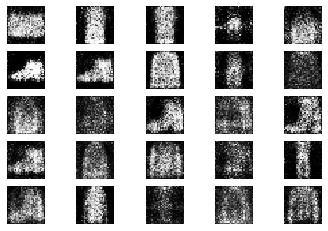

1551 [D loss: 0.558618, acc.: 71.88%] [G loss: 0.927368]
1552 [D loss: 0.625626, acc.: 68.75%] [G loss: 0.933714]
1553 [D loss: 0.615557, acc.: 70.31%] [G loss: 0.912139]
1554 [D loss: 0.599105, acc.: 62.50%] [G loss: 0.856111]
1555 [D loss: 0.581725, acc.: 65.62%] [G loss: 0.923069]
1556 [D loss: 0.619509, acc.: 65.62%] [G loss: 0.931187]
1557 [D loss: 0.627325, acc.: 71.88%] [G loss: 0.902888]
1558 [D loss: 0.604492, acc.: 60.94%] [G loss: 0.792511]
1559 [D loss: 0.557301, acc.: 67.19%] [G loss: 0.767724]
1560 [D loss: 0.614995, acc.: 71.88%] [G loss: 0.933779]
1561 [D loss: 0.643103, acc.: 60.94%] [G loss: 0.905731]
1562 [D loss: 0.592500, acc.: 73.44%] [G loss: 0.946525]
1563 [D loss: 0.563926, acc.: 73.44%] [G loss: 0.944204]
1564 [D loss: 0.684896, acc.: 60.94%] [G loss: 0.936488]
1565 [D loss: 0.709290, acc.: 54.69%] [G loss: 0.900006]
1566 [D loss: 0.682164, acc.: 59.38%] [G loss: 0.897706]
1567 [D loss: 0.557367, acc.: 68.75%] [G loss: 0.935269]
1568 [D loss: 0.645664, acc.: 6

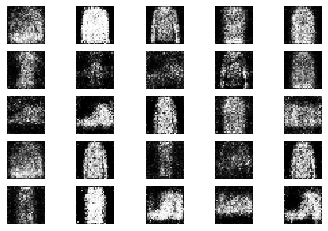

1601 [D loss: 0.556592, acc.: 75.00%] [G loss: 1.025362]
1602 [D loss: 0.572674, acc.: 76.56%] [G loss: 0.935855]
1603 [D loss: 0.588314, acc.: 67.19%] [G loss: 0.878069]
1604 [D loss: 0.614165, acc.: 64.06%] [G loss: 0.878396]
1605 [D loss: 0.606520, acc.: 70.31%] [G loss: 0.906556]
1606 [D loss: 0.591830, acc.: 68.75%] [G loss: 0.837420]
1607 [D loss: 0.603778, acc.: 65.62%] [G loss: 0.896976]
1608 [D loss: 0.602971, acc.: 71.88%] [G loss: 0.962785]
1609 [D loss: 0.546083, acc.: 75.00%] [G loss: 0.949209]
1610 [D loss: 0.582869, acc.: 65.62%] [G loss: 0.889984]
1611 [D loss: 0.656245, acc.: 62.50%] [G loss: 0.932230]
1612 [D loss: 0.630002, acc.: 59.38%] [G loss: 0.963689]
1613 [D loss: 0.601251, acc.: 73.44%] [G loss: 0.953037]
1614 [D loss: 0.619126, acc.: 71.88%] [G loss: 0.976676]
1615 [D loss: 0.639314, acc.: 71.88%] [G loss: 0.912669]
1616 [D loss: 0.607467, acc.: 60.94%] [G loss: 0.904287]
1617 [D loss: 0.631003, acc.: 59.38%] [G loss: 0.848912]
1618 [D loss: 0.548012, acc.: 8

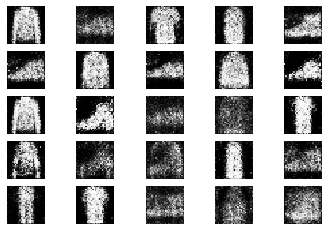

1651 [D loss: 0.703496, acc.: 57.81%] [G loss: 0.875234]
1652 [D loss: 0.607283, acc.: 75.00%] [G loss: 0.915096]
1653 [D loss: 0.603299, acc.: 71.88%] [G loss: 0.965120]
1654 [D loss: 0.627914, acc.: 65.62%] [G loss: 0.878634]
1655 [D loss: 0.602056, acc.: 67.19%] [G loss: 0.888618]
1656 [D loss: 0.651977, acc.: 64.06%] [G loss: 0.946104]
1657 [D loss: 0.576626, acc.: 73.44%] [G loss: 0.971186]
1658 [D loss: 0.594363, acc.: 70.31%] [G loss: 0.952260]
1659 [D loss: 0.606455, acc.: 64.06%] [G loss: 0.933257]
1660 [D loss: 0.605316, acc.: 65.62%] [G loss: 0.858210]
1661 [D loss: 0.583934, acc.: 71.88%] [G loss: 0.854592]
1662 [D loss: 0.574822, acc.: 79.69%] [G loss: 0.917993]
1663 [D loss: 0.628034, acc.: 60.94%] [G loss: 0.929543]
1664 [D loss: 0.643821, acc.: 68.75%] [G loss: 0.953647]
1665 [D loss: 0.634160, acc.: 60.94%] [G loss: 0.882337]
1666 [D loss: 0.622050, acc.: 65.62%] [G loss: 0.873108]
1667 [D loss: 0.526697, acc.: 82.81%] [G loss: 0.978518]
1668 [D loss: 0.600424, acc.: 6

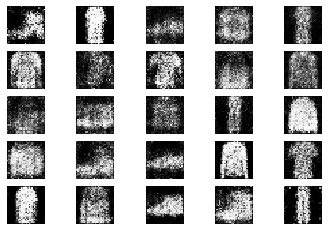

1701 [D loss: 0.603354, acc.: 71.88%] [G loss: 0.840853]
1702 [D loss: 0.649080, acc.: 59.38%] [G loss: 0.857941]
1703 [D loss: 0.651583, acc.: 62.50%] [G loss: 0.942701]
1704 [D loss: 0.598585, acc.: 67.19%] [G loss: 0.873278]
1705 [D loss: 0.659750, acc.: 54.69%] [G loss: 0.916731]
1706 [D loss: 0.608495, acc.: 73.44%] [G loss: 0.918801]
1707 [D loss: 0.561063, acc.: 78.12%] [G loss: 0.922369]
1708 [D loss: 0.608276, acc.: 60.94%] [G loss: 0.876002]
1709 [D loss: 0.534534, acc.: 71.88%] [G loss: 0.988278]
1710 [D loss: 0.571503, acc.: 64.06%] [G loss: 0.992269]
1711 [D loss: 0.566400, acc.: 68.75%] [G loss: 1.000141]
1712 [D loss: 0.619434, acc.: 70.31%] [G loss: 1.027020]
1713 [D loss: 0.589146, acc.: 70.31%] [G loss: 0.954291]
1714 [D loss: 0.616899, acc.: 64.06%] [G loss: 0.996634]
1715 [D loss: 0.564827, acc.: 70.31%] [G loss: 0.964689]
1716 [D loss: 0.650043, acc.: 56.25%] [G loss: 0.906359]
1717 [D loss: 0.691658, acc.: 57.81%] [G loss: 0.882410]
1718 [D loss: 0.622187, acc.: 6

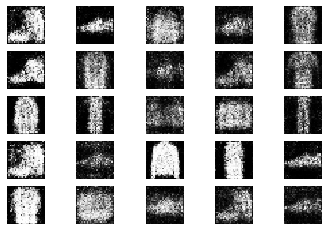

1751 [D loss: 0.630771, acc.: 62.50%] [G loss: 0.862990]
1752 [D loss: 0.639167, acc.: 68.75%] [G loss: 0.814182]
1753 [D loss: 0.600721, acc.: 68.75%] [G loss: 0.829787]
1754 [D loss: 0.643487, acc.: 62.50%] [G loss: 0.937837]
1755 [D loss: 0.669423, acc.: 57.81%] [G loss: 0.834748]
1756 [D loss: 0.596039, acc.: 64.06%] [G loss: 0.859495]
1757 [D loss: 0.647269, acc.: 60.94%] [G loss: 0.978848]
1758 [D loss: 0.650376, acc.: 64.06%] [G loss: 0.846667]
1759 [D loss: 0.633009, acc.: 65.62%] [G loss: 0.858135]
1760 [D loss: 0.653449, acc.: 62.50%] [G loss: 0.946754]
1761 [D loss: 0.589700, acc.: 67.19%] [G loss: 0.930836]
1762 [D loss: 0.636526, acc.: 60.94%] [G loss: 0.974951]
1763 [D loss: 0.600179, acc.: 68.75%] [G loss: 0.921934]
1764 [D loss: 0.619012, acc.: 64.06%] [G loss: 0.911444]
1765 [D loss: 0.650246, acc.: 67.19%] [G loss: 0.848471]
1766 [D loss: 0.591812, acc.: 67.19%] [G loss: 0.974990]
1767 [D loss: 0.637392, acc.: 60.94%] [G loss: 0.888959]
1768 [D loss: 0.682855, acc.: 6

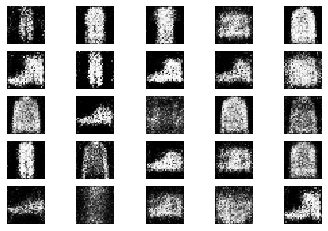

1801 [D loss: 0.644418, acc.: 53.12%] [G loss: 0.887393]
1802 [D loss: 0.573046, acc.: 68.75%] [G loss: 1.066033]
1803 [D loss: 0.665641, acc.: 62.50%] [G loss: 0.963119]
1804 [D loss: 0.596593, acc.: 67.19%] [G loss: 0.986513]
1805 [D loss: 0.617258, acc.: 65.62%] [G loss: 0.967141]
1806 [D loss: 0.655065, acc.: 59.38%] [G loss: 0.920915]
1807 [D loss: 0.546929, acc.: 76.56%] [G loss: 0.866608]
1808 [D loss: 0.582905, acc.: 64.06%] [G loss: 1.029093]
1809 [D loss: 0.608230, acc.: 64.06%] [G loss: 1.027217]
1810 [D loss: 0.574190, acc.: 70.31%] [G loss: 0.962641]
1811 [D loss: 0.584676, acc.: 68.75%] [G loss: 0.964575]
1812 [D loss: 0.607038, acc.: 64.06%] [G loss: 0.995622]
1813 [D loss: 0.660221, acc.: 64.06%] [G loss: 0.947065]
1814 [D loss: 0.625925, acc.: 60.94%] [G loss: 0.868836]
1815 [D loss: 0.645751, acc.: 59.38%] [G loss: 0.911207]
1816 [D loss: 0.683769, acc.: 50.00%] [G loss: 0.883996]
1817 [D loss: 0.536868, acc.: 75.00%] [G loss: 0.932676]
1818 [D loss: 0.604103, acc.: 6

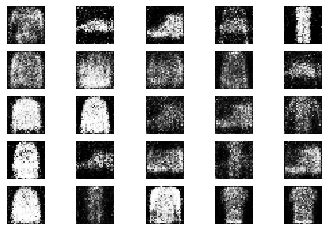

1851 [D loss: 0.625479, acc.: 60.94%] [G loss: 0.920506]
1852 [D loss: 0.633624, acc.: 62.50%] [G loss: 0.950719]
1853 [D loss: 0.616130, acc.: 64.06%] [G loss: 0.901946]
1854 [D loss: 0.561869, acc.: 70.31%] [G loss: 0.946100]
1855 [D loss: 0.609822, acc.: 64.06%] [G loss: 0.941855]
1856 [D loss: 0.579400, acc.: 65.62%] [G loss: 0.833897]
1857 [D loss: 0.588151, acc.: 68.75%] [G loss: 0.907460]
1858 [D loss: 0.620191, acc.: 70.31%] [G loss: 0.911634]
1859 [D loss: 0.637718, acc.: 62.50%] [G loss: 0.891693]
1860 [D loss: 0.665341, acc.: 54.69%] [G loss: 0.902037]
1861 [D loss: 0.547258, acc.: 71.88%] [G loss: 0.956573]
1862 [D loss: 0.655161, acc.: 64.06%] [G loss: 0.936486]
1863 [D loss: 0.592773, acc.: 70.31%] [G loss: 1.029647]
1864 [D loss: 0.687382, acc.: 51.56%] [G loss: 1.000587]
1865 [D loss: 0.592660, acc.: 65.62%] [G loss: 1.064938]
1866 [D loss: 0.615179, acc.: 65.62%] [G loss: 0.992284]
1867 [D loss: 0.589682, acc.: 64.06%] [G loss: 0.895680]
1868 [D loss: 0.681544, acc.: 5

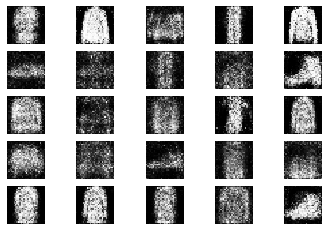

1901 [D loss: 0.606196, acc.: 70.31%] [G loss: 0.875560]
1902 [D loss: 0.540307, acc.: 81.25%] [G loss: 0.933689]
1903 [D loss: 0.623901, acc.: 57.81%] [G loss: 1.011444]
1904 [D loss: 0.614604, acc.: 62.50%] [G loss: 0.921053]
1905 [D loss: 0.508930, acc.: 73.44%] [G loss: 0.928120]
1906 [D loss: 0.641360, acc.: 62.50%] [G loss: 1.030223]
1907 [D loss: 0.645655, acc.: 60.94%] [G loss: 0.931620]
1908 [D loss: 0.637758, acc.: 68.75%] [G loss: 0.892957]
1909 [D loss: 0.543548, acc.: 82.81%] [G loss: 0.946361]
1910 [D loss: 0.650773, acc.: 60.94%] [G loss: 0.862893]
1911 [D loss: 0.646178, acc.: 62.50%] [G loss: 0.934464]
1912 [D loss: 0.664130, acc.: 60.94%] [G loss: 0.917704]
1913 [D loss: 0.669288, acc.: 57.81%] [G loss: 0.982493]
1914 [D loss: 0.550671, acc.: 79.69%] [G loss: 0.914192]
1915 [D loss: 0.638118, acc.: 60.94%] [G loss: 0.891953]
1916 [D loss: 0.651195, acc.: 62.50%] [G loss: 0.979055]
1917 [D loss: 0.630717, acc.: 68.75%] [G loss: 0.994478]
1918 [D loss: 0.646990, acc.: 6

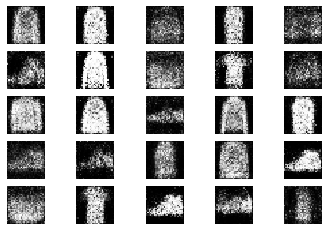

1951 [D loss: 0.600954, acc.: 64.06%] [G loss: 0.905884]
1952 [D loss: 0.606152, acc.: 67.19%] [G loss: 0.902658]
1953 [D loss: 0.619891, acc.: 67.19%] [G loss: 0.897346]
1954 [D loss: 0.662307, acc.: 57.81%] [G loss: 0.891730]
1955 [D loss: 0.635034, acc.: 65.62%] [G loss: 1.032465]
1956 [D loss: 0.710944, acc.: 50.00%] [G loss: 0.819557]
1957 [D loss: 0.663546, acc.: 57.81%] [G loss: 0.838432]
1958 [D loss: 0.626316, acc.: 60.94%] [G loss: 0.929477]
1959 [D loss: 0.644370, acc.: 57.81%] [G loss: 0.944624]
1960 [D loss: 0.696918, acc.: 56.25%] [G loss: 0.919517]
1961 [D loss: 0.611877, acc.: 64.06%] [G loss: 0.955751]
1962 [D loss: 0.654555, acc.: 59.38%] [G loss: 0.948092]
1963 [D loss: 0.618844, acc.: 67.19%] [G loss: 0.923364]
1964 [D loss: 0.625477, acc.: 64.06%] [G loss: 0.892366]
1965 [D loss: 0.581452, acc.: 73.44%] [G loss: 0.977756]
1966 [D loss: 0.626606, acc.: 62.50%] [G loss: 0.950072]
1967 [D loss: 0.629834, acc.: 59.38%] [G loss: 0.933310]
1968 [D loss: 0.550998, acc.: 7

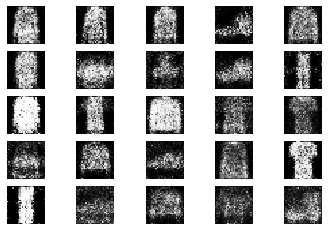

2001 [D loss: 0.652897, acc.: 62.50%] [G loss: 0.980219]
2002 [D loss: 0.689974, acc.: 56.25%] [G loss: 0.915828]
2003 [D loss: 0.635728, acc.: 64.06%] [G loss: 0.888245]
2004 [D loss: 0.612383, acc.: 75.00%] [G loss: 0.859770]
2005 [D loss: 0.636579, acc.: 64.06%] [G loss: 0.929933]
2006 [D loss: 0.677306, acc.: 60.94%] [G loss: 1.032657]
2007 [D loss: 0.571073, acc.: 73.44%] [G loss: 0.932353]
2008 [D loss: 0.618393, acc.: 60.94%] [G loss: 0.885676]
2009 [D loss: 0.607979, acc.: 64.06%] [G loss: 0.845926]
2010 [D loss: 0.610600, acc.: 62.50%] [G loss: 0.912496]
2011 [D loss: 0.651314, acc.: 62.50%] [G loss: 0.840074]
2012 [D loss: 0.567958, acc.: 71.88%] [G loss: 0.925543]
2013 [D loss: 0.561736, acc.: 71.88%] [G loss: 0.892959]
2014 [D loss: 0.612713, acc.: 68.75%] [G loss: 0.929291]
2015 [D loss: 0.640608, acc.: 60.94%] [G loss: 0.913874]
2016 [D loss: 0.550771, acc.: 76.56%] [G loss: 0.870378]
2017 [D loss: 0.604615, acc.: 67.19%] [G loss: 0.961355]
2018 [D loss: 0.604206, acc.: 7

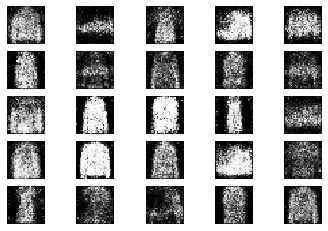

2051 [D loss: 0.632494, acc.: 60.94%] [G loss: 0.902605]
2052 [D loss: 0.655939, acc.: 53.12%] [G loss: 0.955216]
2053 [D loss: 0.646127, acc.: 64.06%] [G loss: 0.980492]
2054 [D loss: 0.599490, acc.: 73.44%] [G loss: 0.969555]
2055 [D loss: 0.636850, acc.: 60.94%] [G loss: 1.017008]
2056 [D loss: 0.632100, acc.: 62.50%] [G loss: 0.946448]
2057 [D loss: 0.690494, acc.: 57.81%] [G loss: 1.009250]
2058 [D loss: 0.620640, acc.: 68.75%] [G loss: 1.048362]
2059 [D loss: 0.675463, acc.: 57.81%] [G loss: 0.940188]
2060 [D loss: 0.615824, acc.: 73.44%] [G loss: 0.883161]
2061 [D loss: 0.584482, acc.: 68.75%] [G loss: 0.914380]
2062 [D loss: 0.578576, acc.: 78.12%] [G loss: 1.017329]
2063 [D loss: 0.574617, acc.: 70.31%] [G loss: 0.955053]
2064 [D loss: 0.606118, acc.: 62.50%] [G loss: 0.964179]
2065 [D loss: 0.678078, acc.: 57.81%] [G loss: 0.916459]
2066 [D loss: 0.621516, acc.: 62.50%] [G loss: 0.898557]
2067 [D loss: 0.622847, acc.: 65.62%] [G loss: 0.876371]
2068 [D loss: 0.559936, acc.: 7

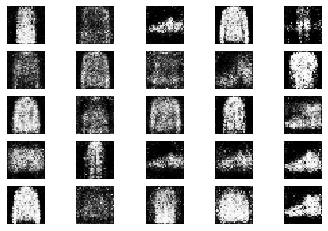

2101 [D loss: 0.619178, acc.: 64.06%] [G loss: 0.984768]
2102 [D loss: 0.711545, acc.: 59.38%] [G loss: 0.938960]
2103 [D loss: 0.627860, acc.: 68.75%] [G loss: 1.030138]
2104 [D loss: 0.557415, acc.: 70.31%] [G loss: 1.030091]
2105 [D loss: 0.678606, acc.: 54.69%] [G loss: 0.946697]
2106 [D loss: 0.607390, acc.: 70.31%] [G loss: 0.971798]
2107 [D loss: 0.582616, acc.: 68.75%] [G loss: 0.957967]
2108 [D loss: 0.667480, acc.: 54.69%] [G loss: 0.954528]
2109 [D loss: 0.640738, acc.: 60.94%] [G loss: 0.872555]
2110 [D loss: 0.600939, acc.: 64.06%] [G loss: 0.999125]
2111 [D loss: 0.593366, acc.: 70.31%] [G loss: 1.037114]
2112 [D loss: 0.603778, acc.: 70.31%] [G loss: 0.983588]
2113 [D loss: 0.674120, acc.: 59.38%] [G loss: 0.978023]
2114 [D loss: 0.633188, acc.: 68.75%] [G loss: 0.849533]
2115 [D loss: 0.553461, acc.: 79.69%] [G loss: 0.901522]
2116 [D loss: 0.572288, acc.: 73.44%] [G loss: 1.008567]
2117 [D loss: 0.567391, acc.: 64.06%] [G loss: 0.869274]
2118 [D loss: 0.560106, acc.: 7

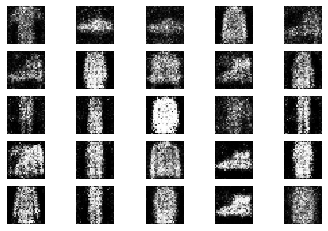

2151 [D loss: 0.604454, acc.: 62.50%] [G loss: 0.984295]
2152 [D loss: 0.588386, acc.: 71.88%] [G loss: 0.969444]
2153 [D loss: 0.554635, acc.: 78.12%] [G loss: 0.916824]
2154 [D loss: 0.580524, acc.: 65.62%] [G loss: 0.889573]
2155 [D loss: 0.639968, acc.: 67.19%] [G loss: 0.898425]
2156 [D loss: 0.622765, acc.: 62.50%] [G loss: 1.001336]
2157 [D loss: 0.702869, acc.: 56.25%] [G loss: 1.021871]
2158 [D loss: 0.608251, acc.: 67.19%] [G loss: 0.866019]
2159 [D loss: 0.727632, acc.: 51.56%] [G loss: 0.929896]
2160 [D loss: 0.606813, acc.: 68.75%] [G loss: 0.937950]
2161 [D loss: 0.657232, acc.: 56.25%] [G loss: 0.940340]
2162 [D loss: 0.593048, acc.: 70.31%] [G loss: 0.992247]
2163 [D loss: 0.551099, acc.: 73.44%] [G loss: 1.129795]
2164 [D loss: 0.615138, acc.: 60.94%] [G loss: 0.958526]
2165 [D loss: 0.633241, acc.: 56.25%] [G loss: 1.026656]
2166 [D loss: 0.632273, acc.: 67.19%] [G loss: 1.024451]
2167 [D loss: 0.630304, acc.: 71.88%] [G loss: 1.027020]
2168 [D loss: 0.558686, acc.: 7

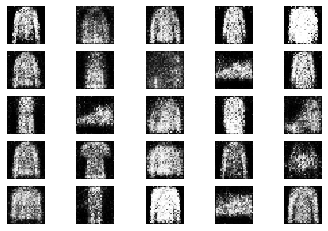

2201 [D loss: 0.593220, acc.: 73.44%] [G loss: 0.980462]
2202 [D loss: 0.647453, acc.: 56.25%] [G loss: 0.930906]
2203 [D loss: 0.561185, acc.: 70.31%] [G loss: 0.937059]
2204 [D loss: 0.559078, acc.: 75.00%] [G loss: 1.085716]
2205 [D loss: 0.603669, acc.: 65.62%] [G loss: 1.033841]
2206 [D loss: 0.597077, acc.: 73.44%] [G loss: 0.908786]
2207 [D loss: 0.611769, acc.: 65.62%] [G loss: 0.997973]
2208 [D loss: 0.668861, acc.: 59.38%] [G loss: 0.893251]
2209 [D loss: 0.611493, acc.: 68.75%] [G loss: 0.994214]
2210 [D loss: 0.582197, acc.: 70.31%] [G loss: 0.982513]
2211 [D loss: 0.561491, acc.: 75.00%] [G loss: 0.910670]
2212 [D loss: 0.650902, acc.: 56.25%] [G loss: 0.946741]
2213 [D loss: 0.671130, acc.: 60.94%] [G loss: 0.934613]
2214 [D loss: 0.673317, acc.: 64.06%] [G loss: 0.891275]
2215 [D loss: 0.651354, acc.: 65.62%] [G loss: 0.911562]
2216 [D loss: 0.603713, acc.: 67.19%] [G loss: 1.031809]
2217 [D loss: 0.585523, acc.: 73.44%] [G loss: 0.934730]
2218 [D loss: 0.555136, acc.: 7

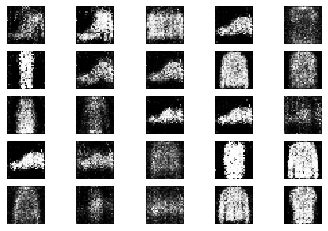

2251 [D loss: 0.616253, acc.: 65.62%] [G loss: 0.917094]
2252 [D loss: 0.603620, acc.: 62.50%] [G loss: 1.019583]
2253 [D loss: 0.574495, acc.: 71.88%] [G loss: 0.986746]
2254 [D loss: 0.617534, acc.: 65.62%] [G loss: 0.949584]
2255 [D loss: 0.571101, acc.: 71.88%] [G loss: 0.913586]
2256 [D loss: 0.671415, acc.: 59.38%] [G loss: 0.880087]
2257 [D loss: 0.655148, acc.: 64.06%] [G loss: 0.997254]
2258 [D loss: 0.594864, acc.: 64.06%] [G loss: 0.891928]
2259 [D loss: 0.603406, acc.: 70.31%] [G loss: 0.913467]
2260 [D loss: 0.657803, acc.: 54.69%] [G loss: 0.897796]
2261 [D loss: 0.607917, acc.: 76.56%] [G loss: 0.973539]
2262 [D loss: 0.591811, acc.: 67.19%] [G loss: 0.911366]
2263 [D loss: 0.620301, acc.: 62.50%] [G loss: 1.011568]
2264 [D loss: 0.590014, acc.: 71.88%] [G loss: 1.035144]
2265 [D loss: 0.601081, acc.: 65.62%] [G loss: 0.959658]
2266 [D loss: 0.618956, acc.: 64.06%] [G loss: 0.948373]
2267 [D loss: 0.612285, acc.: 62.50%] [G loss: 1.056505]
2268 [D loss: 0.548077, acc.: 7

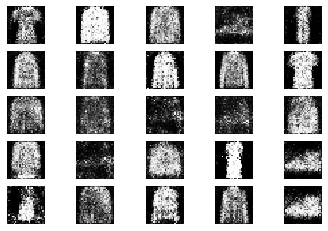

2301 [D loss: 0.606124, acc.: 65.62%] [G loss: 0.954296]
2302 [D loss: 0.616037, acc.: 64.06%] [G loss: 0.938581]
2303 [D loss: 0.606753, acc.: 73.44%] [G loss: 0.904666]
2304 [D loss: 0.545093, acc.: 82.81%] [G loss: 0.996222]
2305 [D loss: 0.607596, acc.: 62.50%] [G loss: 0.995206]
2306 [D loss: 0.591226, acc.: 76.56%] [G loss: 0.904528]
2307 [D loss: 0.638498, acc.: 64.06%] [G loss: 0.848000]
2308 [D loss: 0.617078, acc.: 67.19%] [G loss: 0.984528]
2309 [D loss: 0.494009, acc.: 75.00%] [G loss: 0.925631]
2310 [D loss: 0.601012, acc.: 70.31%] [G loss: 1.020675]
2311 [D loss: 0.576887, acc.: 70.31%] [G loss: 0.911107]
2312 [D loss: 0.615290, acc.: 68.75%] [G loss: 0.920280]
2313 [D loss: 0.635794, acc.: 68.75%] [G loss: 0.939184]
2314 [D loss: 0.604812, acc.: 68.75%] [G loss: 0.930388]
2315 [D loss: 0.674556, acc.: 57.81%] [G loss: 0.984243]
2316 [D loss: 0.634059, acc.: 62.50%] [G loss: 0.988350]
2317 [D loss: 0.563809, acc.: 68.75%] [G loss: 0.863755]
2318 [D loss: 0.598233, acc.: 7

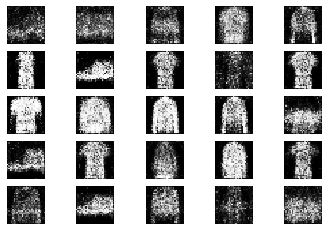

2351 [D loss: 0.614690, acc.: 65.62%] [G loss: 0.930047]
2352 [D loss: 0.563893, acc.: 81.25%] [G loss: 0.982019]
2353 [D loss: 0.562436, acc.: 76.56%] [G loss: 0.986148]
2354 [D loss: 0.683492, acc.: 60.94%] [G loss: 0.940074]
2355 [D loss: 0.572840, acc.: 75.00%] [G loss: 0.940678]
2356 [D loss: 0.630906, acc.: 56.25%] [G loss: 0.928769]
2357 [D loss: 0.654803, acc.: 62.50%] [G loss: 0.932385]
2358 [D loss: 0.597481, acc.: 67.19%] [G loss: 0.998568]
2359 [D loss: 0.568855, acc.: 68.75%] [G loss: 0.974336]
2360 [D loss: 0.585030, acc.: 75.00%] [G loss: 0.926648]
2361 [D loss: 0.606491, acc.: 67.19%] [G loss: 0.936827]
2362 [D loss: 0.607476, acc.: 68.75%] [G loss: 0.990733]
2363 [D loss: 0.623265, acc.: 62.50%] [G loss: 0.897269]
2364 [D loss: 0.608210, acc.: 65.62%] [G loss: 0.918285]
2365 [D loss: 0.622131, acc.: 64.06%] [G loss: 0.912799]
2366 [D loss: 0.717657, acc.: 59.38%] [G loss: 0.989504]
2367 [D loss: 0.546642, acc.: 81.25%] [G loss: 0.936310]
2368 [D loss: 0.621440, acc.: 6

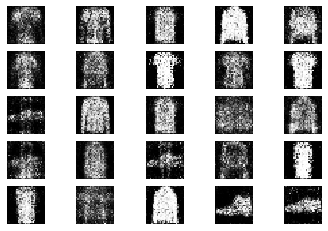

2401 [D loss: 0.580046, acc.: 70.31%] [G loss: 1.026034]
2402 [D loss: 0.530643, acc.: 76.56%] [G loss: 0.955479]
2403 [D loss: 0.552423, acc.: 70.31%] [G loss: 0.942790]
2404 [D loss: 0.588056, acc.: 71.88%] [G loss: 0.996272]
2405 [D loss: 0.664620, acc.: 57.81%] [G loss: 0.929703]
2406 [D loss: 0.621797, acc.: 59.38%] [G loss: 1.025209]
2407 [D loss: 0.651267, acc.: 56.25%] [G loss: 0.930968]
2408 [D loss: 0.574733, acc.: 70.31%] [G loss: 1.056700]
2409 [D loss: 0.641690, acc.: 68.75%] [G loss: 0.961594]
2410 [D loss: 0.653627, acc.: 59.38%] [G loss: 0.989944]
2411 [D loss: 0.666856, acc.: 56.25%] [G loss: 1.002749]
2412 [D loss: 0.621301, acc.: 62.50%] [G loss: 0.957036]
2413 [D loss: 0.581252, acc.: 73.44%] [G loss: 0.992611]
2414 [D loss: 0.666924, acc.: 54.69%] [G loss: 0.837438]
2415 [D loss: 0.601040, acc.: 62.50%] [G loss: 1.018395]
2416 [D loss: 0.619064, acc.: 64.06%] [G loss: 0.949208]
2417 [D loss: 0.549658, acc.: 76.56%] [G loss: 0.924516]
2418 [D loss: 0.583408, acc.: 7

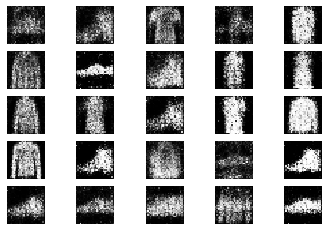

2451 [D loss: 0.602814, acc.: 70.31%] [G loss: 0.916750]
2452 [D loss: 0.601845, acc.: 70.31%] [G loss: 0.903302]
2453 [D loss: 0.625909, acc.: 62.50%] [G loss: 1.071592]
2454 [D loss: 0.660686, acc.: 56.25%] [G loss: 0.869398]
2455 [D loss: 0.667973, acc.: 59.38%] [G loss: 0.905923]
2456 [D loss: 0.626156, acc.: 57.81%] [G loss: 0.984876]
2457 [D loss: 0.624931, acc.: 62.50%] [G loss: 1.015645]
2458 [D loss: 0.639919, acc.: 59.38%] [G loss: 0.957115]
2459 [D loss: 0.649627, acc.: 59.38%] [G loss: 0.959899]
2460 [D loss: 0.586651, acc.: 68.75%] [G loss: 0.959174]
2461 [D loss: 0.511540, acc.: 75.00%] [G loss: 0.944762]
2462 [D loss: 0.678983, acc.: 53.12%] [G loss: 0.893454]
2463 [D loss: 0.608472, acc.: 68.75%] [G loss: 0.961025]
2464 [D loss: 0.614865, acc.: 73.44%] [G loss: 0.944607]
2465 [D loss: 0.582267, acc.: 65.62%] [G loss: 0.933813]
2466 [D loss: 0.649172, acc.: 59.38%] [G loss: 0.961306]
2467 [D loss: 0.559936, acc.: 65.62%] [G loss: 0.961700]
2468 [D loss: 0.614926, acc.: 6

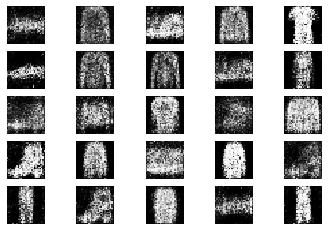

2501 [D loss: 0.547462, acc.: 68.75%] [G loss: 1.005505]
2502 [D loss: 0.553329, acc.: 71.88%] [G loss: 0.903843]
2503 [D loss: 0.579211, acc.: 73.44%] [G loss: 0.913283]
2504 [D loss: 0.573130, acc.: 71.88%] [G loss: 0.907568]
2505 [D loss: 0.623362, acc.: 59.38%] [G loss: 0.916687]
2506 [D loss: 0.781706, acc.: 40.62%] [G loss: 0.968169]
2507 [D loss: 0.568208, acc.: 71.88%] [G loss: 0.952106]
2508 [D loss: 0.631255, acc.: 65.62%] [G loss: 0.990687]
2509 [D loss: 0.599414, acc.: 67.19%] [G loss: 0.918179]
2510 [D loss: 0.594882, acc.: 73.44%] [G loss: 0.790556]
2511 [D loss: 0.603650, acc.: 67.19%] [G loss: 0.908364]
2512 [D loss: 0.665652, acc.: 64.06%] [G loss: 0.991604]
2513 [D loss: 0.591870, acc.: 64.06%] [G loss: 0.891344]
2514 [D loss: 0.578333, acc.: 68.75%] [G loss: 0.983496]
2515 [D loss: 0.656754, acc.: 65.62%] [G loss: 1.039772]
2516 [D loss: 0.649914, acc.: 57.81%] [G loss: 1.087581]
2517 [D loss: 0.589323, acc.: 60.94%] [G loss: 0.912186]
2518 [D loss: 0.690095, acc.: 5

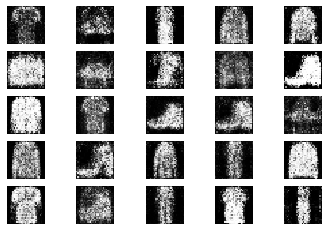

2551 [D loss: 0.605760, acc.: 71.88%] [G loss: 0.885026]
2552 [D loss: 0.637065, acc.: 56.25%] [G loss: 0.866093]
2553 [D loss: 0.667331, acc.: 64.06%] [G loss: 0.866989]
2554 [D loss: 0.582023, acc.: 70.31%] [G loss: 0.890751]
2555 [D loss: 0.567390, acc.: 73.44%] [G loss: 0.950835]
2556 [D loss: 0.556033, acc.: 71.88%] [G loss: 0.923594]
2557 [D loss: 0.605676, acc.: 64.06%] [G loss: 0.993528]
2558 [D loss: 0.604642, acc.: 71.88%] [G loss: 0.956365]
2559 [D loss: 0.616587, acc.: 54.69%] [G loss: 0.934889]
2560 [D loss: 0.619187, acc.: 57.81%] [G loss: 1.033704]
2561 [D loss: 0.643006, acc.: 64.06%] [G loss: 0.979803]
2562 [D loss: 0.642324, acc.: 59.38%] [G loss: 0.879687]
2563 [D loss: 0.621725, acc.: 59.38%] [G loss: 0.880185]
2564 [D loss: 0.636091, acc.: 68.75%] [G loss: 1.019357]
2565 [D loss: 0.623165, acc.: 64.06%] [G loss: 1.035386]
2566 [D loss: 0.668733, acc.: 54.69%] [G loss: 0.938696]
2567 [D loss: 0.606570, acc.: 64.06%] [G loss: 1.086129]
2568 [D loss: 0.631427, acc.: 6

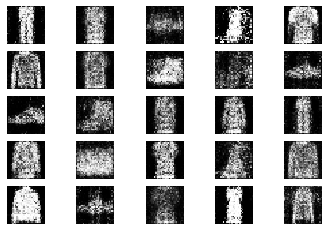

2601 [D loss: 0.610328, acc.: 60.94%] [G loss: 1.025729]
2602 [D loss: 0.573901, acc.: 75.00%] [G loss: 0.904818]
2603 [D loss: 0.618613, acc.: 60.94%] [G loss: 0.942190]
2604 [D loss: 0.593016, acc.: 64.06%] [G loss: 1.008895]
2605 [D loss: 0.629936, acc.: 62.50%] [G loss: 0.946415]
2606 [D loss: 0.513926, acc.: 78.12%] [G loss: 1.048539]
2607 [D loss: 0.650097, acc.: 56.25%] [G loss: 0.948628]
2608 [D loss: 0.648151, acc.: 64.06%] [G loss: 0.905363]
2609 [D loss: 0.645830, acc.: 59.38%] [G loss: 0.897663]
2610 [D loss: 0.634014, acc.: 60.94%] [G loss: 0.993709]
2611 [D loss: 0.646306, acc.: 70.31%] [G loss: 0.968349]
2612 [D loss: 0.645166, acc.: 53.12%] [G loss: 0.981777]
2613 [D loss: 0.627559, acc.: 57.81%] [G loss: 1.010858]
2614 [D loss: 0.607682, acc.: 65.62%] [G loss: 0.951773]
2615 [D loss: 0.598837, acc.: 62.50%] [G loss: 0.993185]
2616 [D loss: 0.613956, acc.: 64.06%] [G loss: 0.918545]
2617 [D loss: 0.638276, acc.: 59.38%] [G loss: 1.004117]
2618 [D loss: 0.606328, acc.: 6

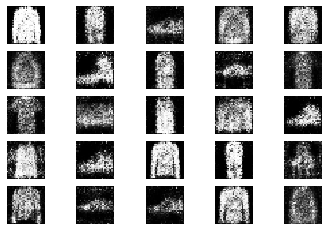

2651 [D loss: 0.613650, acc.: 68.75%] [G loss: 0.963264]
2652 [D loss: 0.602383, acc.: 62.50%] [G loss: 1.003871]
2653 [D loss: 0.582310, acc.: 71.88%] [G loss: 0.985358]
2654 [D loss: 0.637121, acc.: 57.81%] [G loss: 0.994515]
2655 [D loss: 0.617446, acc.: 64.06%] [G loss: 1.038954]
2656 [D loss: 0.637881, acc.: 54.69%] [G loss: 0.939331]
2657 [D loss: 0.615577, acc.: 64.06%] [G loss: 0.871807]
2658 [D loss: 0.583284, acc.: 65.62%] [G loss: 0.967391]
2659 [D loss: 0.609252, acc.: 62.50%] [G loss: 0.886950]
2660 [D loss: 0.679413, acc.: 57.81%] [G loss: 0.970466]
2661 [D loss: 0.617081, acc.: 65.62%] [G loss: 0.994340]
2662 [D loss: 0.668958, acc.: 57.81%] [G loss: 0.894345]
2663 [D loss: 0.646408, acc.: 51.56%] [G loss: 0.880005]
2664 [D loss: 0.659178, acc.: 62.50%] [G loss: 0.920689]
2665 [D loss: 0.551123, acc.: 76.56%] [G loss: 0.979712]
2666 [D loss: 0.641042, acc.: 57.81%] [G loss: 0.907015]
2667 [D loss: 0.635494, acc.: 62.50%] [G loss: 0.901219]
2668 [D loss: 0.556825, acc.: 7

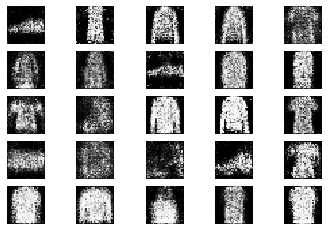

2701 [D loss: 0.620303, acc.: 60.94%] [G loss: 0.952781]
2702 [D loss: 0.582238, acc.: 75.00%] [G loss: 0.937293]
2703 [D loss: 0.597984, acc.: 64.06%] [G loss: 0.933611]
2704 [D loss: 0.606899, acc.: 64.06%] [G loss: 0.984666]
2705 [D loss: 0.686419, acc.: 60.94%] [G loss: 1.004868]
2706 [D loss: 0.611276, acc.: 62.50%] [G loss: 0.969362]
2707 [D loss: 0.554032, acc.: 78.12%] [G loss: 1.031509]
2708 [D loss: 0.574405, acc.: 70.31%] [G loss: 1.045606]
2709 [D loss: 0.588198, acc.: 65.62%] [G loss: 1.035634]
2710 [D loss: 0.581434, acc.: 75.00%] [G loss: 0.948989]
2711 [D loss: 0.539471, acc.: 70.31%] [G loss: 0.921835]
2712 [D loss: 0.655125, acc.: 65.62%] [G loss: 0.824663]
2713 [D loss: 0.668813, acc.: 62.50%] [G loss: 0.948050]
2714 [D loss: 0.617436, acc.: 67.19%] [G loss: 0.856874]
2715 [D loss: 0.704785, acc.: 51.56%] [G loss: 0.932215]
2716 [D loss: 0.577661, acc.: 64.06%] [G loss: 1.020841]
2717 [D loss: 0.626241, acc.: 65.62%] [G loss: 1.069497]
2718 [D loss: 0.541676, acc.: 7

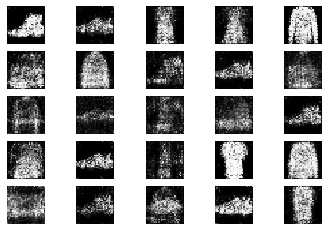

2751 [D loss: 0.606837, acc.: 67.19%] [G loss: 0.976686]
2752 [D loss: 0.572920, acc.: 68.75%] [G loss: 0.979615]
2753 [D loss: 0.599855, acc.: 62.50%] [G loss: 1.124221]
2754 [D loss: 0.580643, acc.: 68.75%] [G loss: 0.962416]
2755 [D loss: 0.629445, acc.: 62.50%] [G loss: 0.983572]
2756 [D loss: 0.650361, acc.: 59.38%] [G loss: 0.980531]
2757 [D loss: 0.660341, acc.: 59.38%] [G loss: 0.984830]
2758 [D loss: 0.641697, acc.: 65.62%] [G loss: 0.970421]
2759 [D loss: 0.616419, acc.: 64.06%] [G loss: 0.975242]
2760 [D loss: 0.628180, acc.: 62.50%] [G loss: 1.015798]
2761 [D loss: 0.622686, acc.: 64.06%] [G loss: 0.931450]
2762 [D loss: 0.620131, acc.: 60.94%] [G loss: 1.060043]
2763 [D loss: 0.666591, acc.: 60.94%] [G loss: 1.036936]
2764 [D loss: 0.605127, acc.: 65.62%] [G loss: 0.937547]
2765 [D loss: 0.662388, acc.: 60.94%] [G loss: 0.838837]
2766 [D loss: 0.628245, acc.: 60.94%] [G loss: 0.900966]
2767 [D loss: 0.589635, acc.: 65.62%] [G loss: 0.936550]
2768 [D loss: 0.658868, acc.: 6

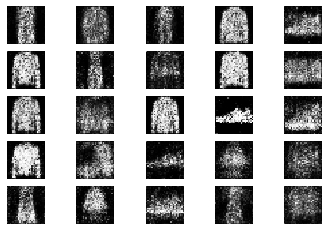

2801 [D loss: 0.610015, acc.: 59.38%] [G loss: 0.921757]
2802 [D loss: 0.588754, acc.: 65.62%] [G loss: 0.918607]
2803 [D loss: 0.633719, acc.: 54.69%] [G loss: 0.899986]
2804 [D loss: 0.559555, acc.: 71.88%] [G loss: 0.868812]
2805 [D loss: 0.638979, acc.: 59.38%] [G loss: 0.986995]
2806 [D loss: 0.573582, acc.: 70.31%] [G loss: 0.948521]
2807 [D loss: 0.614329, acc.: 62.50%] [G loss: 0.865872]
2808 [D loss: 0.566041, acc.: 75.00%] [G loss: 0.897054]
2809 [D loss: 0.578642, acc.: 71.88%] [G loss: 0.926607]
2810 [D loss: 0.599726, acc.: 64.06%] [G loss: 0.939965]
2811 [D loss: 0.589007, acc.: 71.88%] [G loss: 0.952662]
2812 [D loss: 0.695124, acc.: 57.81%] [G loss: 0.969252]
2813 [D loss: 0.627225, acc.: 60.94%] [G loss: 1.041095]
2814 [D loss: 0.671739, acc.: 59.38%] [G loss: 1.039427]
2815 [D loss: 0.634727, acc.: 65.62%] [G loss: 0.978920]
2816 [D loss: 0.610340, acc.: 65.62%] [G loss: 0.886773]
2817 [D loss: 0.705896, acc.: 53.12%] [G loss: 1.072047]
2818 [D loss: 0.625249, acc.: 6

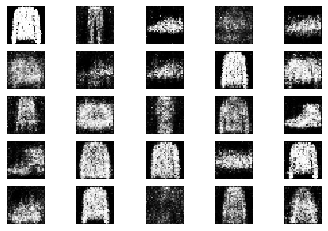

2851 [D loss: 0.583557, acc.: 70.31%] [G loss: 0.976980]
2852 [D loss: 0.569008, acc.: 71.88%] [G loss: 0.911187]
2853 [D loss: 0.574905, acc.: 71.88%] [G loss: 0.903186]
2854 [D loss: 0.638741, acc.: 70.31%] [G loss: 0.930783]
2855 [D loss: 0.581533, acc.: 73.44%] [G loss: 1.009387]
2856 [D loss: 0.610740, acc.: 65.62%] [G loss: 0.930632]
2857 [D loss: 0.622084, acc.: 68.75%] [G loss: 0.964837]
2858 [D loss: 0.651884, acc.: 67.19%] [G loss: 0.797633]
2859 [D loss: 0.634179, acc.: 60.94%] [G loss: 0.917807]
2860 [D loss: 0.561243, acc.: 75.00%] [G loss: 1.046706]
2861 [D loss: 0.572564, acc.: 67.19%] [G loss: 0.974365]
2862 [D loss: 0.614499, acc.: 62.50%] [G loss: 1.014417]
2863 [D loss: 0.607425, acc.: 64.06%] [G loss: 1.024405]
2864 [D loss: 0.626962, acc.: 65.62%] [G loss: 0.897045]
2865 [D loss: 0.604783, acc.: 68.75%] [G loss: 0.927127]
2866 [D loss: 0.600406, acc.: 62.50%] [G loss: 0.973920]
2867 [D loss: 0.571679, acc.: 68.75%] [G loss: 0.986535]
2868 [D loss: 0.604216, acc.: 6

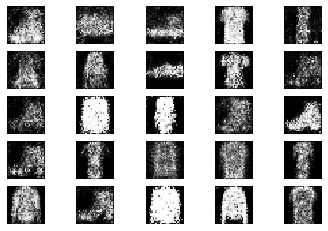

2901 [D loss: 0.593949, acc.: 68.75%] [G loss: 0.953706]
2902 [D loss: 0.687999, acc.: 57.81%] [G loss: 0.918038]
2903 [D loss: 0.706146, acc.: 54.69%] [G loss: 0.937548]
2904 [D loss: 0.619344, acc.: 64.06%] [G loss: 0.938195]
2905 [D loss: 0.690836, acc.: 48.44%] [G loss: 0.919959]
2906 [D loss: 0.516890, acc.: 79.69%] [G loss: 0.997570]
2907 [D loss: 0.534807, acc.: 78.12%] [G loss: 0.949727]
2908 [D loss: 0.615769, acc.: 64.06%] [G loss: 0.840465]
2909 [D loss: 0.624233, acc.: 57.81%] [G loss: 0.986101]
2910 [D loss: 0.631393, acc.: 60.94%] [G loss: 0.977566]
2911 [D loss: 0.580303, acc.: 71.88%] [G loss: 0.923068]
2912 [D loss: 0.672595, acc.: 62.50%] [G loss: 0.942195]
2913 [D loss: 0.619090, acc.: 64.06%] [G loss: 1.007125]
2914 [D loss: 0.536015, acc.: 78.12%] [G loss: 0.912446]
2915 [D loss: 0.678868, acc.: 56.25%] [G loss: 0.918066]
2916 [D loss: 0.609860, acc.: 68.75%] [G loss: 0.979794]
2917 [D loss: 0.589192, acc.: 73.44%] [G loss: 0.992311]
2918 [D loss: 0.631116, acc.: 5

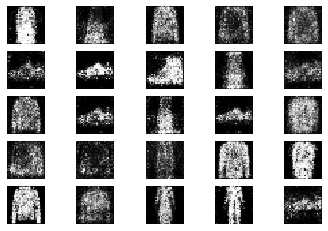

2951 [D loss: 0.683623, acc.: 54.69%] [G loss: 1.027901]
2952 [D loss: 0.594654, acc.: 60.94%] [G loss: 0.862701]
2953 [D loss: 0.576966, acc.: 68.75%] [G loss: 0.972246]
2954 [D loss: 0.597089, acc.: 62.50%] [G loss: 0.859129]
2955 [D loss: 0.620927, acc.: 67.19%] [G loss: 0.966087]
2956 [D loss: 0.632749, acc.: 60.94%] [G loss: 1.058777]
2957 [D loss: 0.575155, acc.: 68.75%] [G loss: 1.079686]
2958 [D loss: 0.601443, acc.: 68.75%] [G loss: 1.004065]
2959 [D loss: 0.701144, acc.: 57.81%] [G loss: 0.919627]
2960 [D loss: 0.577389, acc.: 67.19%] [G loss: 0.903549]
2961 [D loss: 0.606045, acc.: 62.50%] [G loss: 0.912371]
2962 [D loss: 0.551657, acc.: 68.75%] [G loss: 0.893573]
2963 [D loss: 0.599188, acc.: 68.75%] [G loss: 0.987837]
2964 [D loss: 0.552731, acc.: 71.88%] [G loss: 1.009273]
2965 [D loss: 0.570783, acc.: 73.44%] [G loss: 0.939036]
2966 [D loss: 0.597541, acc.: 71.88%] [G loss: 1.051380]
2967 [D loss: 0.698489, acc.: 53.12%] [G loss: 0.930804]
2968 [D loss: 0.673070, acc.: 5

In [14]:
# Training process
epochs = 3000

batch_size = 32
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
  # Train discriminator
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]

  noise = np.random.normal(0, 1, (batch_size, 100))

  gen_imgs = generator.predict(noise)

  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

  # Train generator
  noise = np.random.normal(0, 1, (batch_size, 100))

  g_loss = combined.train_on_batch(noise, valid)

  print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

  if epoch % 50 == 0:
    sample_images(epoch)

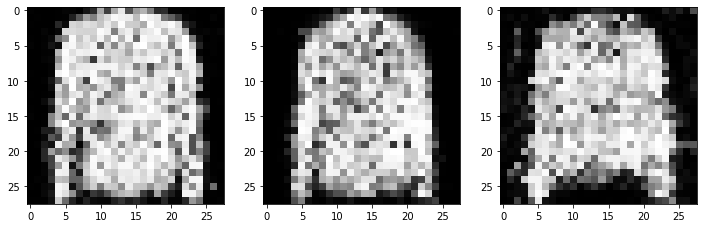

In [15]:
# Run predictions
r, c = 5, 5
noise = np.random.normal(0, 1, (r*c, 100))
gen_imgs = generator.predict(noise)

gen_imgs = 0.5*gen_imgs+0.5

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
plt.subplot(132)
plt.imshow(gen_imgs[1, :, :, 0], cmap='gray')
plt.subplot(133)
plt.imshow(gen_imgs[2, :, :, 0], cmap='gray')
plt.show()
plt.close()